In [3]:
# imports
import pandas as pd
import geopandas as gpd
import geojson
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry
import geopy
from geopy.geocoders import Nominatim
import plotly
import plotly.express as px
import json
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [4]:
# for matplotlib figures have a better pixels to save image
plt.rcParams['figure.dpi'] = 150

In [5]:
# upload geodata
annual_increase_deforestation_2008_2018 = gpd.read_file('annual_increase_deforestation_2008_2018/yearly_deforestation_2008_2018.shp')
states_amazon = gpd.read_file('states_amazon_biome/states_amazon_biome.shp')

In [6]:
# import pandas profiling and check it's verion
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [7]:
# pandas profiling report for for wrangling purposes (drop column 'geometry' which contains polygons)
from pandas_profiling import ProfileReport
profile = ProfileReport(annual_increase_deforestation_2008_2018.drop(columns=['geometry']), minimal=True).to_notebook_iframe()

profile

In [8]:
# feature engineering and clean up data

def clean_up(X):
    X = X.copy()
    
    # lowercase column names
    X.columns = map(str.lower, X.columns)
    
    # retrieve latitude and longitude from geometry polygon
    X['lon'] = X.centroid.x
    X['lat'] = X.centroid.y
    
    # get the month, year, and day
    X['view_date'] = pd.to_datetime(X['view_date'])
    X['day'] = pd.to_datetime(X['view_date']).dt.day
    X['month'] = pd.to_datetime(X['view_date']).dt.month
    X['year'] = pd.to_datetime(X['view_date']).dt.year
        
    # give the column proper name
    X = X.rename(columns={'areakm': 'areakm_squared'}) 
    
    # add states names # ['Para', 'Mato Grosso', 'Rondonia', 'Amazonias', 'Acre', 'Roraima', 'Amapa', 'Tocantins']
    X['states'] = X['uf'].replace({'PA': 'Para', 'MT': 'Mato Grosso', 'RO': 'Rondonia', 'AM': 'Amazonas',
                                   'MA': 'Maranhao', 'AC': 'Acre', 'RR': 'Roraima',
                                  'AP': 'Amapa', 'TO': 'Tocantins'})
    # remove multipolygons
    X = X.drop(columns=['geometry'])
    
    # remove outliers (values that are more than 3 standard deviations from the mean)
    z_scores = zscore(X['areakm_squared'])
    z_scores_abs = np.abs(z_scores)
    z_scores_abs
    z_scores_filtered = z_scores < 3
    X = X[z_scores_filtered]
    
    # get rid of zeros
    cols_with_zeros = ['scene_id', 'dsfnv', 'areakm_squared']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
    
    return X

In [9]:
# shape of the original dataset
annual_increase_deforestation_2008_2018.shape

(474930, 14)

In [10]:
# clean up dataset and check it's shape
df_2008_2018 = clean_up(annual_increase_deforestation_2008_2018)
df_2008_2018.shape

(471054, 19)

In [11]:
# sample set for future use on heroku app
sample = df_2008_2018.sample(frac=0.1, replace=False)
sample.shape

(47105, 19)

In [12]:
# sample to csv format
sample.to_csv('sample.csv', index=False)

In [13]:
# data exploration population set
df_2008_2018['areakm_squared'].describe()

count    4.709290e+05
mean     1.303403e-01
std      1.529017e-01
min      1.000000e-15
25%      6.497929e-02
50%      8.891423e-02
75%      1.442154e-01
max      1.440085e+00
Name: areakm_squared, dtype: float64

In [14]:
# data wrangling exploration population set
areakm_by_year = pd.DataFrame([df_2008_2018.groupby('year')['areakm_squared'].sum()])
areakm_by_year = areakm_by_year.T
areakm_by_year

areakm_squared
year                
2008    10890.855721
2009     5443.646141
2010     5788.204947
2011     5086.563828
2012     3873.186869
2013     4443.135347
2014     4229.917756
2015     6113.520541
2016     4588.059961
2017     5572.896625
2018     5351.036378

In [15]:
# data wrangling exploration population set
areakm_by_state = pd.DataFrame([df_2008_2018.groupby('states')['areakm_squared'].sum()])
areakm_by_state = areakm_by_state.T
areakm_by_state

areakm_squared
states                     
Acre            3064.692439
Amapa            383.985201
Amazonas        5762.305637
Maranhao        4571.588553
Mato Grosso    10390.374355
Para           26126.737316
Rondonia        8651.627904
Roraima         1969.111211
Tocantins        460.601498

In [16]:
# data wrangling exploration population set
areakm_by_state = areakm_by_state.reset_index()
areakm_by_state

states  areakm_squared
0         Acre     3064.692439
1        Amapa      383.985201
2     Amazonas     5762.305637
3     Maranhao     4571.588553
4  Mato Grosso    10390.374355
5         Para    26126.737316
6     Rondonia     8651.627904
7      Roraima     1969.111211
8    Tocantins      460.601498

In [17]:
# data wrangling exploration population set
areakm_by_state_year = pd.DataFrame([df_2008_2018.groupby(['states', 'year'])['areakm_squared'].sum()])
areakm_by_state_year = areakm_by_state_year.stack()
areakm_by_state_year

states                     Acre      Amapa    Amazonas     Maranhao  \
               year                                                   
areakm_squared 2008  287.322895  99.915680  537.239787  1311.719155   
               2009  161.738944  48.166831  337.060808   683.916337   
               2010  265.366856  72.366287  530.803059   546.061749   
               2011  289.090163  16.766478  472.615220   347.519436   
               2012  270.597273  19.527490  419.415997   304.785185   
               2013  200.240071  24.783779  424.059727   268.375789   
               2014  348.609567  29.105426  467.668678   251.397671   
               2015  381.971892  19.557604  587.672709   276.877778   
               2016  202.921254  11.965681  606.463272   149.045892   
               2017  245.887606  17.268303  687.441754   258.927445   
               2018  410.945918  24.561641  691.864625   172.962117   

states               Mato Grosso         Para     Rondonia     Roraima  \
               year                                                      
areakm_squared 2008  2343.887221  4696.604324  1004.515811  517.645668   
               2009   674.126358  2967.626822   413.279173  111.324740   
               2010   591.076649  3094.670893   413.290897  226.150983   
               2011   803.045902  2307.864850   695.561654  125.020565   
               2012   627.214235  1466.020867   622.273896  101.495129   
               2013   865.155787  1644.458860   838.601175  133.250710   
               2014   795.678225  1466.480688   667.403760  167.991512   
               2015  1184.804218  2359.159400  1073.531309  183.529463   
               2016   779.194980  1787.267916   841.319117  180.835928   
               2017   922.388495  2248.488110  1064.600952  103.096137   
               2018   803.802286  2088.094586  1017.250160  118.770377   

states               Tocantins  
               year             
areakm_squared 2008  92.005182  
               2009  46.406128  
               2010  48.417575  
               2011  29.079561  
               2012  41.856796  
               2013  44.209449  
               2014  35.582228  
               2015  46.416169  
               2016  29.045920  
               2017  24.797823  
               2018  22.784667

In [18]:
# data wrangling exploration population set
areakm_by_state_year = areakm_by_state_year.T
areakm_by_state_year

areakm_squared                                         \
year                  2008         2009         2010         2011   
states                                                              
Acre            287.322895   161.738944   265.366856   289.090163   
Amapa            99.915680    48.166831    72.366287    16.766478   
Amazonas        537.239787   337.060808   530.803059   472.615220   
Maranhao       1311.719155   683.916337   546.061749   347.519436   
Mato Grosso    2343.887221   674.126358   591.076649   803.045902   
Para           4696.604324  2967.626822  3094.670893  2307.864850   
Rondonia       1004.515811   413.279173   413.290897   695.561654   
Roraima         517.645668   111.324740   226.150983   125.020565   
Tocantins        92.005182    46.406128    48.417575    29.079561   

                                                                              \
year                2012         2013         2014         2015         2016   
states                                                                         
Acre          270.597273   200.240071   348.609567   381.971892   202.921254   
Amapa          19.527490    24.783779    29.105426    19.557604    11.965681   
Amazonas      419.415997   424.059727   467.668678   587.672709   606.463272   
Maranhao      304.785185   268.375789   251.397671   276.877778   149.045892   
Mato Grosso   627.214235   865.155787   795.678225  1184.804218   779.194980   
Para         1466.020867  1644.458860  1466.480688  2359.159400  1787.267916   
Rondonia      622.273896   838.601175   667.403760  1073.531309   841.319117   
Roraima       101.495129   133.250710   167.991512   183.529463   180.835928   
Tocantins      41.856796    44.209449    35.582228    46.416169    29.045920   

                                       
year                2017         2018  
states                                 
Acre          245.887606   410.945918  
Amapa          17.268303    24.561641  
Amazonas      687.441754   691.864625  
Maranhao      258.927445   172.962117  
Mato Grosso   922.388495   803.802286  
Para         2248.488110  2088.094586  
Rondonia     1064.600952  1017.250160  
Roraima       103.096137   118.770377  
Tocantins      24.797823    22.784667

In [19]:
# data wrangling exploration population set
areakm_by_state_year = areakm_by_state_year.reset_index()
areakm_by_state_year

states areakm_squared                                         \
year                        2008         2009         2010         2011   
0            Acre     287.322895   161.738944   265.366856   289.090163   
1           Amapa      99.915680    48.166831    72.366287    16.766478   
2        Amazonas     537.239787   337.060808   530.803059   472.615220   
3        Maranhao    1311.719155   683.916337   546.061749   347.519436   
4     Mato Grosso    2343.887221   674.126358   591.076649   803.045902   
5            Para    4696.604324  2967.626822  3094.670893  2307.864850   
6        Rondonia    1004.515811   413.279173   413.290897   695.561654   
7         Roraima     517.645668   111.324740   226.150983   125.020565   
8       Tocantins      92.005182    46.406128    48.417575    29.079561   

                                                                       \
year         2012         2013         2014         2015         2016   
0      270.597273   200.240071   348.609567   381.971892   202.921254   
1       19.527490    24.783779    29.105426    19.557604    11.965681   
2      419.415997   424.059727   467.668678   587.672709   606.463272   
3      304.785185   268.375789   251.397671   276.877778   149.045892   
4      627.214235   865.155787   795.678225  1184.804218   779.194980   
5     1466.020867  1644.458860  1466.480688  2359.159400  1787.267916   
6      622.273896   838.601175   667.403760  1073.531309   841.319117   
7      101.495129   133.250710   167.991512   183.529463   180.835928   
8       41.856796    44.209449    35.582228    46.416169    29.045920   

                                
year         2017         2018  
0      245.887606   410.945918  
1       17.268303    24.561641  
2      687.441754   691.864625  
3      258.927445   172.962117  
4      922.388495   803.802286  
5     2248.488110  2088.094586  
6     1064.600952  1017.250160  
7      103.096137   118.770377  
8       24.797823    22.784667

In [20]:
# data wrangling exploration population set
print(areakm_by_state_year.columns)

MultiIndex([(        'states',   ''),
            ('areakm_squared', 2008),
            ('areakm_squared', 2009),
            ('areakm_squared', 2010),
            ('areakm_squared', 2011),
            ('areakm_squared', 2012),
            ('areakm_squared', 2013),
            ('areakm_squared', 2014),
            ('areakm_squared', 2015),
            ('areakm_squared', 2016),
            ('areakm_squared', 2017),
            ('areakm_squared', 2018)],
           names=[None, 'year'])


In [21]:
# data wrangling exploration population set
areakm_by_state_year = pd.DataFrame({'states': ['Acre', 'Amapa', 'Amazonas', 'Maranhao', 'Mato Grosso', 'Para', 'Rondonia', 'Roraima', 'Tocantins'],
                                    '2008': areakm_by_state_year[('areakm_squared', 2008)],
                                     '2009': areakm_by_state_year[('areakm_squared', 2009)],
                                     '2010': areakm_by_state_year[('areakm_squared', 2010)],
                                     '2011': areakm_by_state_year[('areakm_squared', 2011)],
                                     '2012': areakm_by_state_year[('areakm_squared', 2012)],
                                     '2013': areakm_by_state_year[('areakm_squared', 2013)],
                                     '2014': areakm_by_state_year[('areakm_squared', 2014)],
                                     '2015': areakm_by_state_year[('areakm_squared', 2015)],
                                     '2016': areakm_by_state_year[('areakm_squared', 2016)],
                                     '2017': areakm_by_state_year[('areakm_squared', 2017)],
                                     '2018': areakm_by_state_year[('areakm_squared', 2018)]
                   })
areakm_by_state_year

states         2008         2009         2010         2011  \
0         Acre   287.322895   161.738944   265.366856   289.090163   
1        Amapa    99.915680    48.166831    72.366287    16.766478   
2     Amazonas   537.239787   337.060808   530.803059   472.615220   
3     Maranhao  1311.719155   683.916337   546.061749   347.519436   
4  Mato Grosso  2343.887221   674.126358   591.076649   803.045902   
5         Para  4696.604324  2967.626822  3094.670893  2307.864850   
6     Rondonia  1004.515811   413.279173   413.290897   695.561654   
7      Roraima   517.645668   111.324740   226.150983   125.020565   
8    Tocantins    92.005182    46.406128    48.417575    29.079561   

          2012         2013         2014         2015         2016  \
0   270.597273   200.240071   348.609567   381.971892   202.921254   
1    19.527490    24.783779    29.105426    19.557604    11.965681   
2   419.415997   424.059727   467.668678   587.672709   606.463272   
3   304.785185   268.375789   251.397671   276.877778   149.045892   
4   627.214235   865.155787   795.678225  1184.804218   779.194980   
5  1466.020867  1644.458860  1466.480688  2359.159400  1787.267916   
6   622.273896   838.601175   667.403760  1073.531309   841.319117   
7   101.495129   133.250710   167.991512   183.529463   180.835928   
8    41.856796    44.209449    35.582228    46.416169    29.045920   

          2017         2018  
0   245.887606   410.945918  
1    17.268303    24.561641  
2   687.441754   691.864625  
3   258.927445   172.962117  
4   922.388495   803.802286  
5  2248.488110  2088.094586  
6  1064.600952  1017.250160  
7   103.096137   118.770377  
8    24.797823    22.784667

In [22]:
# data wrangling exploration population set
areakm_states_years = areakm_by_state_year.merge(areakm_by_state, on='states', left_index=True) 
areakm_states_years

states         2008         2009         2010         2011  \
0         Acre   287.322895   161.738944   265.366856   289.090163   
1        Amapa    99.915680    48.166831    72.366287    16.766478   
2     Amazonas   537.239787   337.060808   530.803059   472.615220   
3     Maranhao  1311.719155   683.916337   546.061749   347.519436   
4  Mato Grosso  2343.887221   674.126358   591.076649   803.045902   
5         Para  4696.604324  2967.626822  3094.670893  2307.864850   
6     Rondonia  1004.515811   413.279173   413.290897   695.561654   
7      Roraima   517.645668   111.324740   226.150983   125.020565   
8    Tocantins    92.005182    46.406128    48.417575    29.079561   

          2012         2013         2014         2015         2016  \
0   270.597273   200.240071   348.609567   381.971892   202.921254   
1    19.527490    24.783779    29.105426    19.557604    11.965681   
2   419.415997   424.059727   467.668678   587.672709   606.463272   
3   304.785185   268.375789   251.397671   276.877778   149.045892   
4   627.214235   865.155787   795.678225  1184.804218   779.194980   
5  1466.020867  1644.458860  1466.480688  2359.159400  1787.267916   
6   622.273896   838.601175   667.403760  1073.531309   841.319117   
7   101.495129   133.250710   167.991512   183.529463   180.835928   
8    41.856796    44.209449    35.582228    46.416169    29.045920   

          2017         2018  areakm_squared  
0   245.887606   410.945918     3064.692439  
1    17.268303    24.561641      383.985201  
2   687.441754   691.864625     5762.305637  
3   258.927445   172.962117     4571.588553  
4   922.388495   803.802286    10390.374355  
5  2248.488110  2088.094586    26126.737316  
6  1064.600952  1017.250160     8651.627904  
7   103.096137   118.770377     1969.111211  
8    24.797823    22.784667      460.601498

In [23]:
# breaking down population set by year increment
df_2008 = df_2008_2018[df_2008_2018['year'] == 2008]
df_2008_2009 = df_2008_2018[df_2008_2018['year'] <= 2009]
df_2008_2010 = df_2008_2018[df_2008_2018['year'] <= 2010]
df_2008_2011 = df_2008_2018[df_2008_2018['year'] <= 2011]
df_2008_2012 = df_2008_2018[df_2008_2018['year'] <= 2012]
df_2008_2013 = df_2008_2018[df_2008_2018['year'] <= 2013]
df_2008_2014 = df_2008_2018[df_2008_2018['year'] <= 2014]
df_2008_2015 = df_2008_2018[df_2008_2018['year'] <= 2015]
df_2008_2016 = df_2008_2018[df_2008_2018['year'] <= 2016]
df_2008_2017 = df_2008_2018[df_2008_2018['year'] <= 2017]

In [24]:
# breaking down population set by year
df_2009 = df_2008_2018[df_2008_2018['year'] <= 2009]
df_2010 = df_2008_2018[df_2008_2018['year'] == 2010]
df_2011 = df_2008_2018[df_2008_2018['year'] == 2011]
df_2012 = df_2008_2018[df_2008_2018['year'] == 2012]
df_2013 = df_2008_2018[df_2008_2018['year'] == 2013]
df_2014 = df_2008_2018[df_2008_2018['year'] == 2014]
df_2015 = df_2008_2018[df_2008_2018['year'] == 2015]
df_2016 = df_2008_2018[df_2008_2018['year'] == 2016]
df_2017 = df_2008_2018[df_2008_2018['year'] == 2017]
df_2018 = df_2008_2018[df_2008_2018['year'] == 2018]

In [25]:
# exploration of states data set
states_amazon['geometry']

0    MULTIPOLYGON (((-66.62648 -9.90087, -66.62657 ...
1    POLYGON ((-54.00084 2.23030, -54.00077 2.23032...
2    POLYGON ((-73.80065 -7.11215, -73.80098 -7.111...
3    MULTIPOLYGON (((-43.99733 -2.40111, -43.99847 ...
4    MULTIPOLYGON (((-50.25039 -9.83957, -50.26614 ...
5    MULTIPOLYGON (((-46.06634 -1.10459, -46.06909 ...
6    POLYGON ((-59.96165 -12.05642, -59.96981 -12.0...
7    POLYGON ((-60.17060 5.22688, -60.17054 5.22688...
8    MULTIPOLYGON (((-47.87031 -5.28111, -47.87042 ...
Name: geometry, dtype: geometry

In [26]:
# coordinate referene system WGS84 Latitude/Longitude: "EPSG:4326"

def coord_ref(df):
    # copy df
    X = df.copy()
    
    # convert coordinates
    X = X.to_crs("EPSG:4326")
    
    return X

In [27]:
# df_samps = [states_amazon, df_2008, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, df_2017, df_2018, df_2008_2009,
#                 df_2008_2010, df_2008_2011, df_2008_2012, df_2008_2013, df_2008_2014, df_2008_2015, df_2008_2016, df_2008_2017, df_2008_2018]

df_samps = [states_amazon]
for df in df_samps:
    coord_ref(df)


In [28]:
# Working with polygons

# convert to json and make it str
states = json.dumps(shapely.geometry.mapping(states_amazon))

# check type
# type(states) # str

# convert str to geojson
states_geojson = geojson.loads(states)

# states_geojson['type'] # 'FeatureCollection'

# print feature keys
print(states_geojson['features'][0].keys())

# print length
print(len(states_geojson['features']))

# print properties
print(states_geojson['features'][0]['properties'])

# set the locations id matching to polygon id length
states_names_locations_id = [k for k in range(0,9)]

print(states_names_locations_id)

dict_keys(['type', 'bbox', 'id', 'geometry', 'properties'])
9
{'CD_GEOCUF': '12', 'NM_ESTADO': 'ACRE', 'NM_REGIAO': 'NORTE'}
[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [29]:
# # work with polygons on 2008 
# def convert_poly(df):
#     #copy df
#     X = df.copy()
#     # first convert to json string
#     d_X = json.dumps(shapely.geometry.mapping(X))

#     # check type
#     # type(d_X) # str

#     # second convert to geojson object
#     j_X = geojson.loads(d_X)

#     # check type 
#     # type(j_X) # geojson.feature.FeatureCollection

#     # print the features keys
#     print(j_X['features'][0].keys())

#     # print features properties
#     print(j_X['features'][0]['properties'])
    
#     return j_X

In [30]:
areakm_states_years

states         2008         2009         2010         2011  \
0         Acre   287.322895   161.738944   265.366856   289.090163   
1        Amapa    99.915680    48.166831    72.366287    16.766478   
2     Amazonas   537.239787   337.060808   530.803059   472.615220   
3     Maranhao  1311.719155   683.916337   546.061749   347.519436   
4  Mato Grosso  2343.887221   674.126358   591.076649   803.045902   
5         Para  4696.604324  2967.626822  3094.670893  2307.864850   
6     Rondonia  1004.515811   413.279173   413.290897   695.561654   
7      Roraima   517.645668   111.324740   226.150983   125.020565   
8    Tocantins    92.005182    46.406128    48.417575    29.079561   

          2012         2013         2014         2015         2016  \
0   270.597273   200.240071   348.609567   381.971892   202.921254   
1    19.527490    24.783779    29.105426    19.557604    11.965681   
2   419.415997   424.059727   467.668678   587.672709   606.463272   
3   304.785185   268.375789   251.397671   276.877778   149.045892   
4   627.214235   865.155787   795.678225  1184.804218   779.194980   
5  1466.020867  1644.458860  1466.480688  2359.159400  1787.267916   
6   622.273896   838.601175   667.403760  1073.531309   841.319117   
7   101.495129   133.250710   167.991512   183.529463   180.835928   
8    41.856796    44.209449    35.582228    46.416169    29.045920   

          2017         2018  areakm_squared  
0   245.887606   410.945918     3064.692439  
1    17.268303    24.561641      383.985201  
2   687.441754   691.864625     5762.305637  
3   258.927445   172.962117     4571.588553  
4   922.388495   803.802286    10390.374355  
5  2248.488110  2088.094586    26126.737316  
6  1064.600952  1017.250160     8651.627904  
7   103.096137   118.770377     1969.111211  
8    24.797823    22.784667      460.601498

In [31]:
# area km incremented by year
areakm_2008_2009 = areakm_states_years['2008'] + areakm_states_years['2009']
areakm_2008_2010 = areakm_2008_2009 + areakm_states_years['2010']
areakm_2008_2011 = areakm_2008_2010 + areakm_states_years['2011']
areakm_2008_2012 = areakm_2008_2011 + areakm_states_years['2012']
areakm_2008_2013 = areakm_2008_2012 + areakm_states_years['2013']
areakm_2008_2014 = areakm_2008_2013 + areakm_states_years['2014']
areakm_2008_2015 = areakm_2008_2014 + areakm_states_years['2015']
areakm_2008_2016 = areakm_2008_2015 + areakm_states_years['2016']
areakm_2008_2017 = areakm_2008_2016 + areakm_states_years['2017']
areakm_2008_2018 = areakm_2008_2017 + areakm_states_years['2018']

In [32]:
# make a df from area km incremented by year
increasing_areakm = pd.DataFrame({'states': areakm_states_years['states'],
                                  '2008': areakm_states_years['states'],
                                  '2008_2009': areakm_2008_2009,
                                  '2008_2010': areakm_2008_2010,
                                  '2008_2011': areakm_2008_2011,
                                  '2008_2012': areakm_2008_2012,
                                  '2008_2013': areakm_2008_2013,
                                  '2008_2014': areakm_2008_2014,
                                  '2008_2015': areakm_2008_2015,
                                  '2008_2016': areakm_2008_2016,
                                  '2008_2017': areakm_2008_2017,
                                  '2008_2018': areakm_2008_2018}
                                  )
increasing_areakm

states         2008    2008_2009     2008_2010     2008_2011  \
0         Acre         Acre   449.061839    714.428695   1003.518858   
1        Amapa        Amapa   148.082511    220.448798    237.215276   
2     Amazonas     Amazonas   874.300595   1405.103654   1877.718874   
3     Maranhao     Maranhao  1995.635492   2541.697240   2889.216676   
4  Mato Grosso  Mato Grosso  3018.013579   3609.090227   4412.136129   
5         Para         Para  7664.231146  10758.902038  13066.766888   
6     Rondonia     Rondonia  1417.794984   1831.085881   2526.647535   
7      Roraima      Roraima   628.970407    855.121390    980.141955   
8    Tocantins    Tocantins   138.411309    186.828884    215.908445   

      2008_2012     2008_2013     2008_2014     2008_2015     2008_2016  \
0   1274.116131   1474.356202   1822.965769   2204.937661   2407.858915   
1    256.742766    281.526545    310.631972    330.189576    342.155257   
2   2297.134871   2721.194598   3188.863276   3776.535985   4382.999258   
3   3194.001861   3462.377650   3713.775321   3990.653099   4139.698991   
4   5039.350364   5904.506151   6700.184377   7884.988595   8664.183574   
5  14532.787755  16177.246616  17643.727303  20002.886703  21790.154619   
6   3148.921431   3987.522606   4654.926365   5728.457674   6569.776792   
7   1081.637084   1214.887794   1382.879306   1566.408769   1747.244697   
8    257.765242    301.974691    337.556919    383.973088    413.019008   

      2008_2017     2008_2018  
0   2653.746521   3064.692439  
1    359.423559    383.985201  
2   5070.441012   5762.305637  
3   4398.626436   4571.588553  
4   9586.572069  10390.374355  
5  24038.642730  26126.737316  
6   7634.377744   8651.627904  
7   1850.340834   1969.111211  
8    437.816831    460.601498

In [33]:
# import plotly.express as px
# px.set_mapbox_access_token(open("token.txt").read())
# mapboxt = open("token.txt").read()

In [34]:
### TO HEAVY WORK ON HEROKU (NOT USED)


# states_data = [areakm_states_years['2008'], areakm_2008_2009, areakm_2008_2010, areakm_2008_2011, areakm_2008_2012, areakm_2008_2013,
#               areakm_2008_2014, areakm_2008_2015, areakm_2008_2016, areakm_2008_2017, areakm_2008_2018]

# location_data = [df_2008, df_2008_2009, df_2008_2010, df_2008_2011, df_2008_2012, df_2008_2013, df_2008_2014, df_2008_2015, df_2008_2016,
#                 df_2008_2017, df_2008_2018]
# trace1 = []
# trace2 = []
# for state in states_data:
#     trace1.append(go.Choroplethmapbox(z=state,
#                             locations=states_names_locations_id,
#                             colorscale='blues',
#                             colorbar=dict(thickness=20, ticklen=3),
#                             geojson=states_geojson,
#                             text=areakm_states_years['states'],
#                             hoverinfo='all',
#                             marker_line_width=0.1, marker_opacity=0.8,
#                             visible=False))

# for location in location_data:
#     trace2.append(go.Scattermapbox(lat=location['lat'],
#                               lon=location['lon'], 
#                               mode='markers',
#                               text=location['areakm_squared'],
#                               hoverinfo='all',
#                               marker=go.scattermapbox.Marker(
#                               size=3,
#                               color='#E51313',
#                               opacity=0.5)))
    
# len1 = len(trace1) 
# len2 = len(trace2) 
  
# data= [0] *(len1 + len2)  
   
# def alternateMerge(arr1, arr2, n1, n2, arr3) : 
#     i = 0; j = 0; k = 0
  
#     # Traverse both array 
#     while (i < n1 and j < n2) : 
#         arr3[k] = arr1[i] 
#         i += 1
#         k += 1
          
#         arr3[k] = arr2[j] 
#         j += 1
#         k += 1
    
#     return arr3
        
# all_traces = alternateMerge(trace1, trace2, len1, len2, data) 

# for trace in all_traces:
#     trace['visible'] = False
                      
# all_traces[0]['visible'] = True
# all_traces[1]['visible'] = True

# layout = go.Layout(title_text= 'Increased Deforestation by year (2008-2018)',
#                    title_x=0.5, width = 900, height=700,
#                    mapbox = dict(center= dict(lat=-5.977402,  lon=-58.97948),
#                                  accesstoken= mapboxt,
#                                  zoom=3.8,
#                                ))


# layout.update(updatemenus=list([
#         dict(
#             x=-0.05,
#             y=1,
#             yanchor='top',
#             buttons=list([
#                 dict(
#                     args=['visible', [True, True, False, False, False, False, False, False, False, False, False, False, False, False, 
#                                       False, False, False, False, False, False, False, False]],
#                     label='Year: 2008',
#                     method='restyle'
#                 ),
#                 dict(
#                     args=['visible', [False, False, True, True, False, False, False, False, False, False, False, False, False, False, 
#                                       False, False, False, False, False, False, False, False]],
#                     label='Year: 2009',
#                     method='restyle'
#                 ),
#                 dict(
#                     args=['visible', [False, False, False, False, True, True, False, False, False, False, False, False, False, False, 
#                                       False, False, False, False, False, False, False, False]],
#                     label='Year: 2010',
#                     method='restyle'
#                 ),
#                 dict(
#                     args=['visible', [False, False, False, False, False, False, True, True, False, False, False, False, False, False, 
#                                       False, False, False, False, False, False, False, False]],
#                     label='Year: 2011',
#                     method='restyle'
#                 ),
#                 dict(
#                     args=['visible', [False, False, False, False, False, False, False, False, True, True, False, False, False, False, 
#                                       False, False, False, False, False, False, False, False]],
#                     label='Year: 2012',
#                     method='restyle'
#                 ),
#                 dict(
#                     args=['visible', [False, False, False, False, False, False, False, False, False, False, True, True, False, False, 
#                                       False, False, False, False, False, False, False, False]],
#                     label='Year: 2013',
#                     method='restyle'
#                 ),
#                 dict(
#                     args=['visible', [False, False, False, False, False, False, False, False, False, False, False, False, True, True, 
#                                       False, False, False, False, False, False, False, False]],
#                     label='Year: 2014',
#                     method='restyle'
#                 ),
#                 dict(
#                     args=['visible', [False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
#                                       True, True, False, False, False, False, False, False]],
#                     label='Year: 2015',
#                     method='restyle'
#                 ),
#                 dict(
#                     args=['visible', [False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
#                                       False, False, True, True, False, False, False, False]],
#                     label='Year: 2016',
#                     method='restyle'
#                 ),
#                 dict(
#                     args=['visible', [False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
#                                       False, False, False, False, True, True, False, False]],
#                     label='Year: 2017',
#                     method='restyle'
#                 ),
#                 dict(
#                     args=['visible', [False, False, False, False, False, False, False, False, False, False, False, False, False, False, 
#                                       False, False, False, False, False, False, True, True]],
#                     label='Year: 2018',
#                     method='restyle'
#                 )
#             ]),
#         )]))

# fig=go.Figure(data=all_traces, layout=layout)

# for i in range(0,len(fig.data), 2):
#     data[i].hovertemplate =  '<b>State</b>: <b>%{text}</b>'+\
#                         '<br> <b>Total burned area</b>: %{z}<br>'
# for i in range(1, len(fig.data), 2):
#     data[i].hovertemplate =  '<b>Area burned in m^2</b>: <b>%{text:.4f}</b>'+\
#                         '<br>'

    
# # fig.data[0].hovertemplate =  '<b>State</b>: <b>%{text}</b>'+\
# #                               '<br> <b>Total burned area</b>: %{z}<br>'
# # fig.data[1].hovertemplate =  '<b>Area burned in m^2</b>: <b>%{text:.4f}</b>'+\
# #                               '<br>'
# # fig.data[2].hovertemplate =  '<b>State</b>: <b>%{text}</b>'+\
# #                               '<br> <b>Total burned area</b>: %{z}<br>'
# # fig.data[3].hovertemplate =  '<b>Area burned in m^2</b>: <b>%{text:.4f}</b>'+\
# #                               '<br>'
# # fig.data[4].hovertemplate =  '<b>State</b>: <b>%{text}</b>'+\
# #                               '<br> <b>Total burned area</b>: %{z}<br>'
# # fig.data[5].hovertemplate =  '<b>Area burned in m^2</b>: <b>%{text:.4f}</b>'+\
# #                               '<br>'
# # fig.data[6].hovertemplate =  '<b>State</b>: <b>%{text}</b>'+\
# #                               '<br> <b>Total burned area</b>: %{z}<br>'
# # fig.data[7].hovertemplate =  '<b>Area burned in m^2</b>: <b>%{text:.4f}</b>'+\
# #                               '<br>'
# # fig.data[8].hovertemplate =  '<b>State</b>: <b>%{text}</b>'+\
# #                               '<br> <b>Total burned area</b>: %{z}<br>'
# # fig.data[9].hovertemplate =  '<b>Area burned in m^2</b>: <b>%{text:.4f}</b>'+\
# #                               '<br>'
# # fig.data[10].hovertemplate =  '<b>State</b>: <b>%{text}</b>'+\
# #                               '<br> <b>Total burned area</b>: %{z}<br>'
# # fig.data[11].hovertemplate =  '<b>Area burned in m^2</b>: <b>%{text:.4f}</b>'+\
# #                               '<br>'
# # fig.data[12].hovertemplate =  '<b>State</b>: <b>%{text}</b>'+\
# #                               '<br> <b>Total burned area</b>: %{z}<br>'
# # fig.data[13].hovertemplate =  '<b>Area burned in m^2</b>: <b>%{text:.4f}</b>'+\
# #                               '<br>'
# # fig.data[14].hovertemplate =  '<b>State</b>: <b>%{text}</b>'+\
# #                               '<br> <b>Total burned area</b>: %{z}<br>'
# # fig.data[15].hovertemplate =  '<b>Area burned in m^2</b>: <b>%{text:.4f}</b>'+\
# #                               '<br>'
# # fig.data[16].hovertemplate =  '<b>State</b>: <b>%{text}</b>'+\
# #                               '<br> <b>Total burned area</b>: %{z}<br>'
# # fig.data[17].hovertemplate =  '<b>Area burned in m^2</b>: <b>%{text:.4f}</b>'+\
# #                               '<br>'
# # fig.data[18].hovertemplate =  '<b>State</b>: <b>%{text}</b>'+\
# #                               '<br> <b>Total burned area</b>: %{z}<br>'
# # fig.data[19].hovertemplate =  '<b>Area burned in m^2</b>: <b>%{text:.4f}</b>'+\
# #                               '<br>'
# # fig.data[20].hovertemplate =  '<b>State</b>: <b>%{text}</b>'+\
# #                               '<br> <b>Total burned area</b>: %{z}<br>'
# # fig.data[21].hovertemplate =  '<b>Area burned in m^2</b>: <b>%{text:.4f}</b>'+\
# #                               '<br>'

# fig.update_layout(mapbox_style = "streets")
# fig.show()

In [ ]:
## Visualize on Map (NOT USED ON HEROKU APP, SAMPLE SET USED FOR HEROKU) 
mapboxt = open("token.txt").read()
trace = [
        go.Choroplethmapbox(z=areakm_2008_2018,
                            locations=states_names_locations_id,
                            colorscale='blues',
                            name='Deforested area by state in km^2',
                            showlegend=True,
                            colorbar=dict(thickness=20, ticklen=3),
                            geojson=states_geojson,
                            text=areakm_states_years['states'],
                            hoverinfo='all',
                            marker_line_width=0.1, marker_opacity=0.7),
                            
         
        go.Scattermapbox(lat=df_2008_2018['lat'],
                          lon=df_2008_2018['lon'], 
                          name='Location of deforested area',
                          showlegend=True,
                          mode='markers',
                          text=df_2008_2018['areakm_squared'],
                          hoverinfo='all',
                          marker=go.scattermapbox.Marker(
                          size=2,
                          color='#E51313',
                          opacity=1))
        ]
                            
                            
layout = go.Layout(title_text= 'Amazon Deforestation 2008-2018',
                   title_x=0.1, width = 900, height=650,
                   mapbox = dict(center= dict(lat=-5.977402,  lon=-58.97948),
                                 accesstoken= mapboxt,
                                 zoom=3.7,
                               ))

fig = go.Figure(data=trace, layout =layout)

fig.data[0].hovertemplate =  '<b>State</b>: <b>%{text}</b>'+\
                              '<br> <b>Total deforestation in km^2</b>: %{z}<br>'
fig.data[1].hovertemplate =  '<b>Area deforested in km^2</b>: <b>%{text:.4f}</b>'+\
                              '<br>'
fig.update_layout(mapbox_style = "streets")
fig.update_layout(showlegend=True, legend=dict(x=0.7, y=1.17))

In [36]:
######################################################
################ MODELING SECTION ####################
######################################################

In [37]:
# Import everything for models
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

# choose metrics MAE (because leaving some outliers)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [38]:
# base
mean_lon = np.mean(sample['lon'])
print(f'Longitude: {mean_lon}')

mean_lat = np.mean(sample['lat'])
print(f'Latitude: {mean_lat}')

# for exploring purposes (max, min)
# max_lon = df_2008_2018['lon'].max()
# max_lat = df_2008_2018['lat'].max()
# print(f'max lon: {max_lon}')
# print(f'max lat: {max_lat}')

# min_lon = df_2008_2018['lon'].min()
# min_lat = df_2008_2018['lat'].min()

# print(f'min lon: {min_lon}')
# print(f'min lat: {min_lat}')

Longitude: -55.58247202047584
Latitude: -5.986421573071742


In [39]:
# train/val/test split timebased ### very heavy for github or heroku (NOT USED IN HEROKU APP)
train = df_2008_2018[df_2008_2018['year'] <= 2015]
val = df_2008_2018[df_2008_2018['year'] == 2016]
test = df_2008_2018[df_2008_2018['year'] >= 2017]

train.shape, val.shape, test.shape

((350401, 19), (38837, 19), (81816, 19))

In [40]:
# leave 4 decimal places for lat and lon
train = train.round({"lat":4, "lon":4})
val = val.round({'lat':4, 'lon':4})
test = test.round({'lat':4, 'lon':4})

In [41]:
# define target
target1 = 'lat'
target2 = 'lon'

duplicates = ['ano', 'view_date', 'uf', 'julday', 'class_name', 'publish_ye']
useless = ['gid', 'origin_id', 'mainclass', 'pathrow', 'dsfnv','scene_id']

# define features
features = train.drop(columns=[target1] + [target2] + useless + duplicates).columns.tolist()
features

['areakm_squared', 'day', 'month', 'year', 'states']

In [42]:
# Define X matrix and y vector
X_train = train[features]
y_train_1 = train[target1]
y_train_2 = train[target2]
X_val = val[features]
y_val_1 = val[target1]
y_val_2 = val[target2]
X_test = test[features]
y_test_1 = test[target1]
y_test_2 = test[target2]

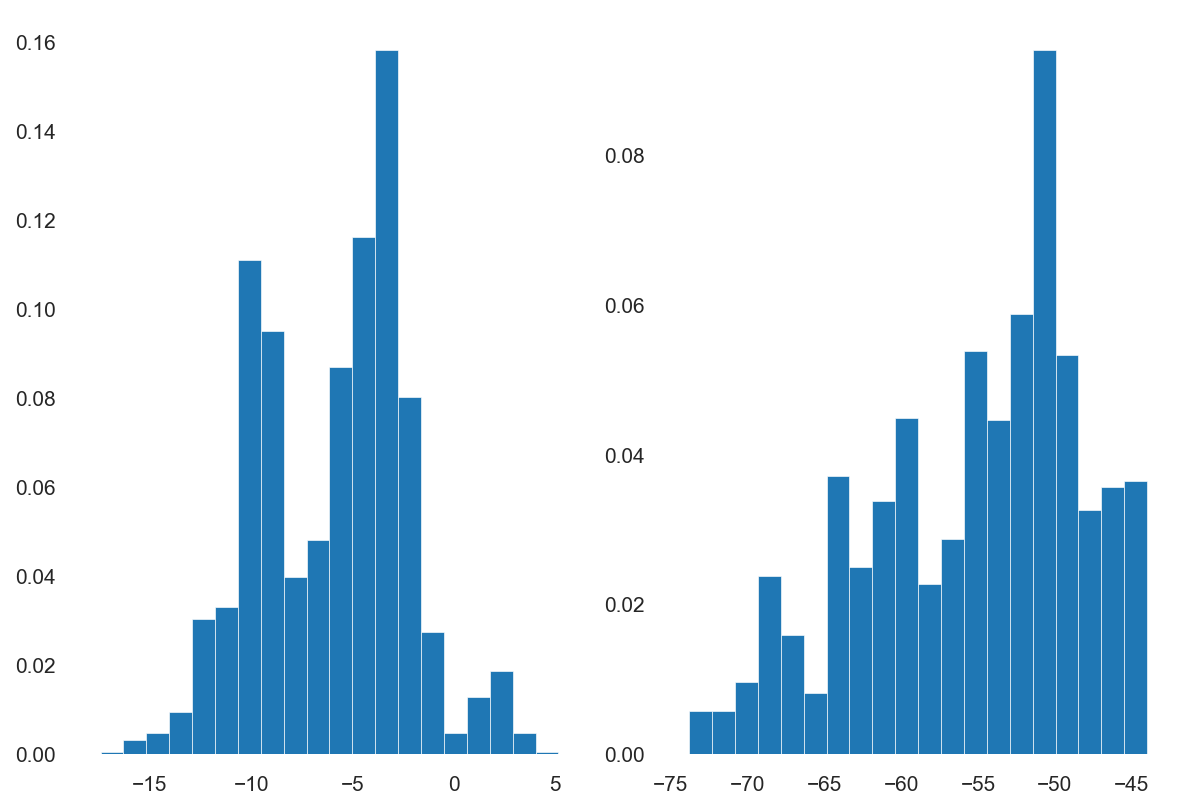

In [43]:
# distribution population data
fig, axs = plt.subplots(1, 2, tight_layout=True)

axs[0].hist(y_train_1, bins=20, density=True)
axs[1].hist(y_train_2, bins=20, density=True);

In [44]:
# Ridge Regression trained on population
ridge_model = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    SelectKBest(f_regression, k='all'), 
    Ridge(alpha=1)
)

ridge_model.fit(X_train, y_train_1)
y_val_pred_1 = ridge_model.predict(X_val)
ridge_model.fit(X_train, y_train_2)
y_val_pred_2 = ridge_model.predict(X_val)

print(f'Ridge model validation MAE: {mean_absolute_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'Ridge model validation MAE: {mean_absolute_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'Ridge model Validation RMSE loss: {mean_squared_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'Ridge model Validation RMSE loss: {mean_squared_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'Ridge model Validation R^2 coefficient: {r2_score(y_val_1, y_val_pred_1):.4f} lat')
print(f'Ridge model Validation R^2 coefficient: {r2_score(y_val_2, y_val_pred_2):.4f} lon')

Ridge model validation MAE: 1.3207 lat
Ridge model validation MAE: 1.8468 lon
Ridge model Validation RMSE loss: 2.8329 lat
Ridge model Validation RMSE loss: 5.4658 lon
Ridge model Validation R^2 coefficient: 0.7949 lat
Ridge model Validation R^2 coefficient: 0.8801 lon


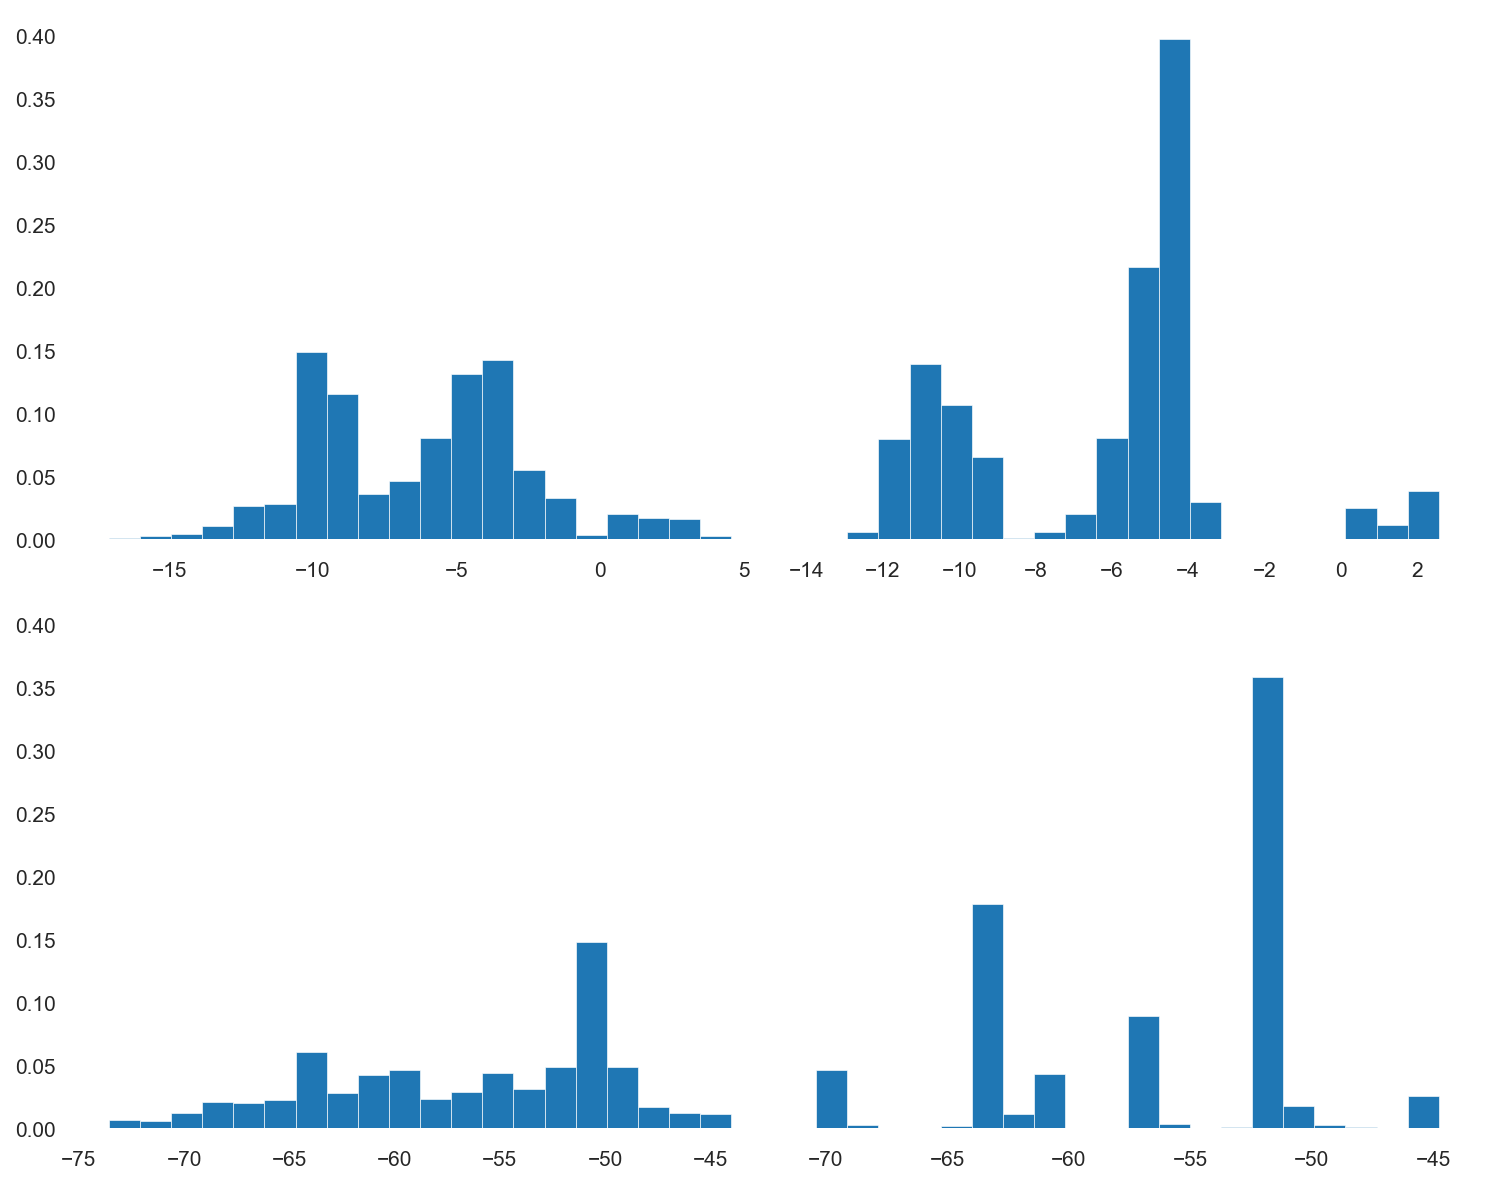

In [45]:
# true distribution vs predicted for Ridge Regression
fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(10,8))

axs[0, 0].hist(y_val_1, bins=20, density=True)
axs[0, 1].hist(y_val_pred_1, bins=20, density=True);
axs[1, 0].hist(y_val_2, bins=20, density=True)
axs[1, 1].hist(y_val_pred_2, bins=20, density=True);

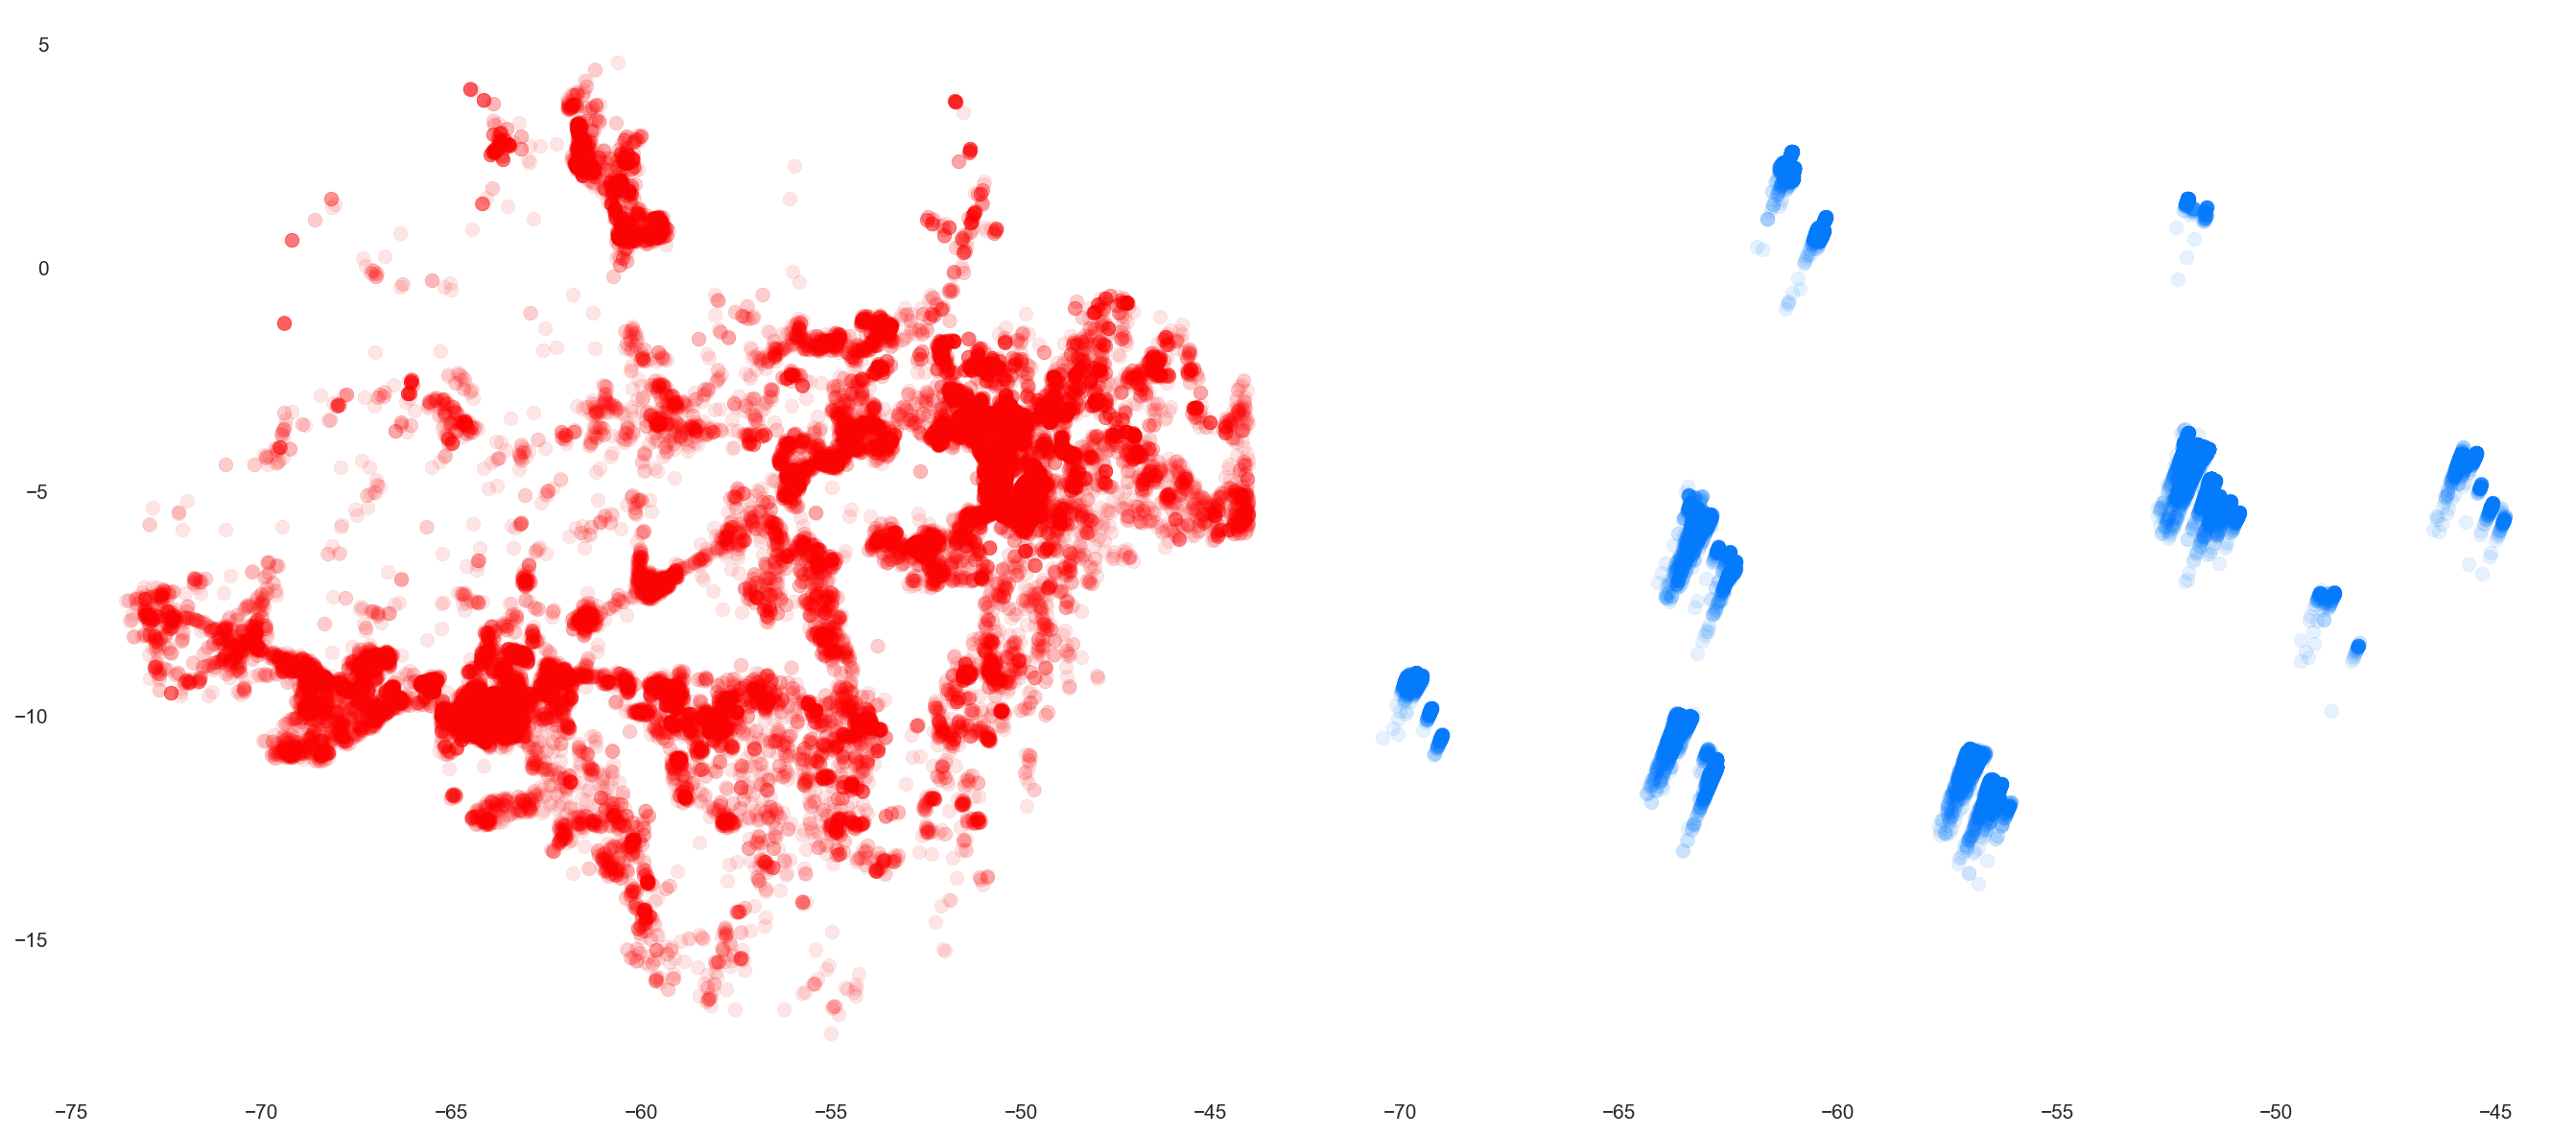

In [47]:
# How Ridge model looks on graph
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(18,8))

axs[0].scatter(x=y_val_2, y=y_val_1, c='#fc0303', alpha=0.1)
axs[1].scatter(x=y_val_pred_2, y=y_val_pred_1, c='#037bfc', alpha=0.1);

In [ ]:
# plotly very heavy for github or heroku
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(mode = 'markers',
               x=y_val_2, 
               y=y_val_1,
               marker = dict(
               color='rgba(17, 157, 255, 0.5)',
               size= 5)),
    row=1, 
    col=1
)

fig.add_trace(
    go.Scatter(mode = 'markers',
               x=y_val_pred_2, 
               y=y_val_pred_1,
               marker = dict(
               color='#E51313',
               opacity=0.5,
               size=5)),
    row=1, col=2
)

fig.update_xaxes(title_text="True Longitude", row=1, col=1)
fig.update_xaxes(title_text="Predicted Longitude", row=1, col=2)
fig.update_yaxes(title_text="True Latitude", row=1, col=1)
fig.update_yaxes(title_text="Predicted Latitude", row=1, col=2)

fig.update_layout(height=500, width=1100, showlegend=False,
                  title_text="Random Forest model prediction True vs Predicted values")
fig.show()

In [48]:
# Desicion Tree Model
# Decision Tree Regressor trained on population
dt1 = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeRegressor(random_state=42)
)
dt2 = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeRegressor(random_state=42)
)

dt1.fit(X_train, y_train_1)
y_val_pred_1 = dt1.predict(X_val)
dt2.fit(X_train, y_train_2)
y_val_pred_2 = dt2.predict(X_val)

print(f'Desicion Tree validation MAE: {mean_absolute_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'Desicion Tree validation MAE: {mean_absolute_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'Desicion Tree Validation RMSE loss: {mean_squared_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'Desicion Tree Validation RMSE loss: {mean_squared_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'Desicion Tree Validation R^2 coefficient: {r2_score(y_val_1, y_val_pred_1):.4f} lat')
print(f'Desicion Tree Validation R^2 coefficient: {r2_score(y_val_2, y_val_pred_2):.4f} lon')

Desicion Tree validation MAE: 2.1791 lat
Desicion Tree validation MAE: 3.3861 lon
Desicion Tree Validation RMSE loss: 7.4978 lat
Desicion Tree Validation RMSE loss: 19.2732 lon
Desicion Tree Validation R^2 coefficient: 0.4571 lat
Desicion Tree Validation R^2 coefficient: 0.5773 lon


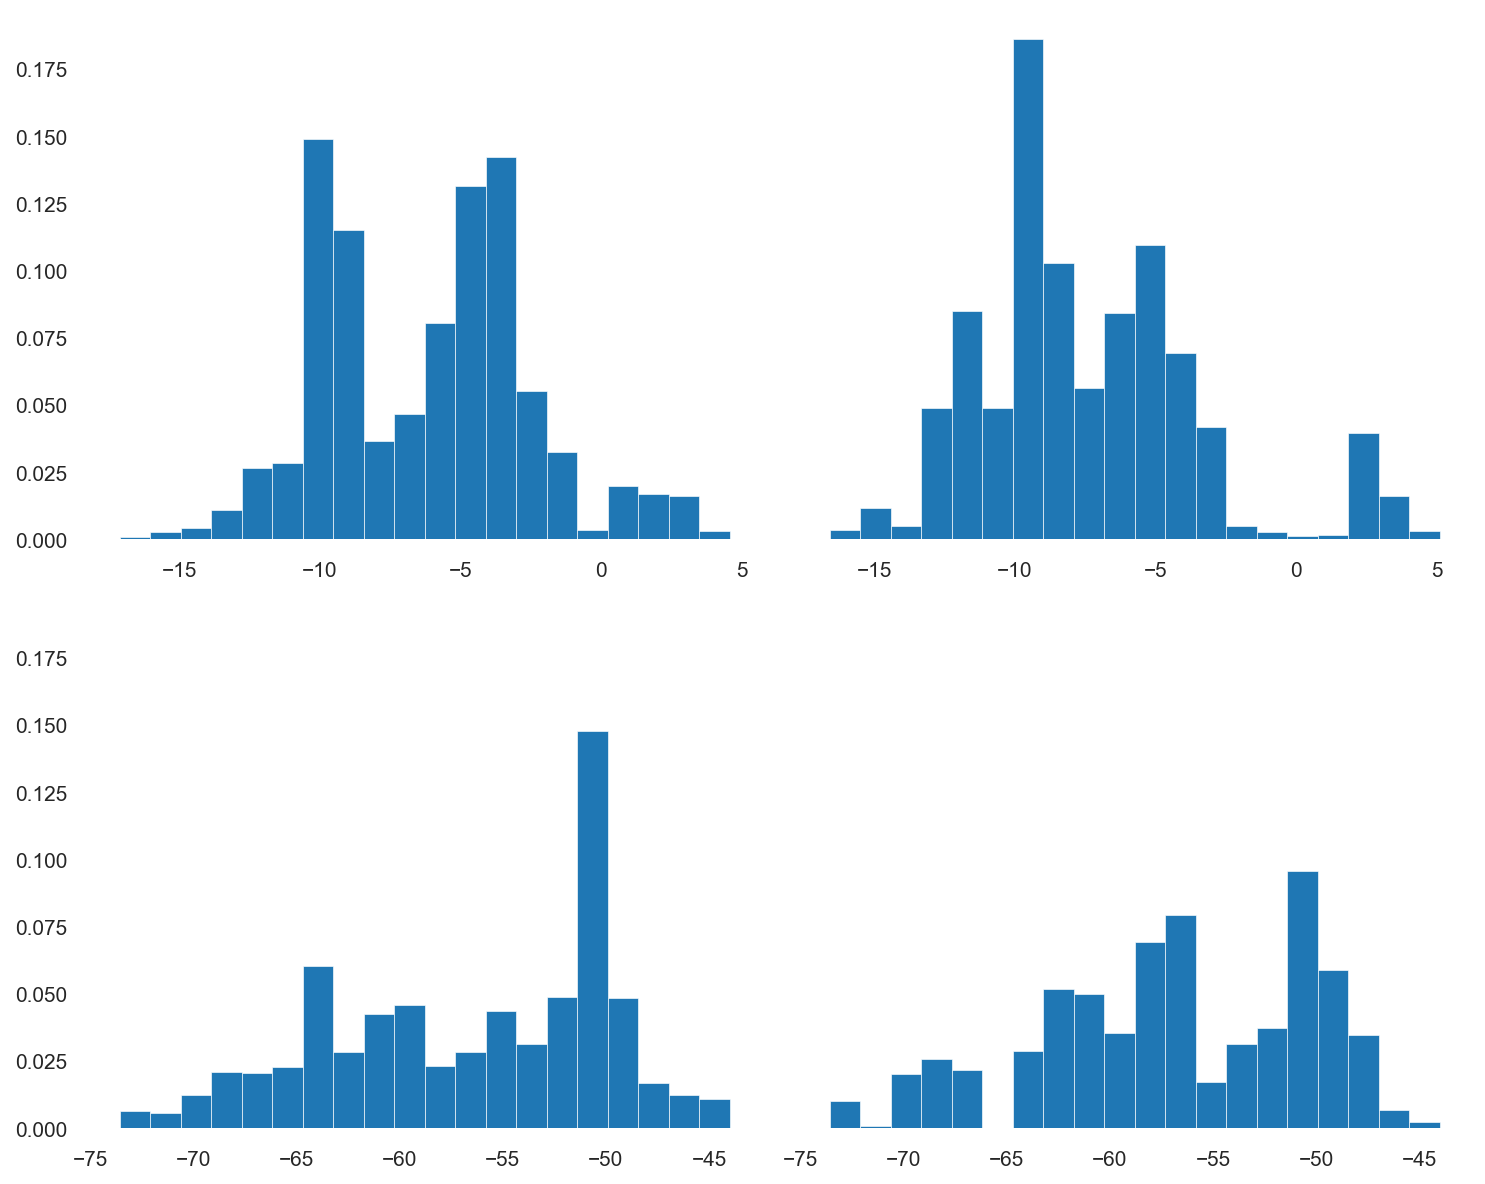

In [49]:
# true vs predicted values distribution decision tree population set
fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(10,8))

axs[0, 0].hist(y_val_1, bins=20, density=True)
axs[0, 1].hist(y_val_pred_1, bins=20, density=True);
axs[1, 0].hist(y_val_2, bins=20, density=True)
axs[1, 1].hist(y_val_pred_2, bins=20, density=True);

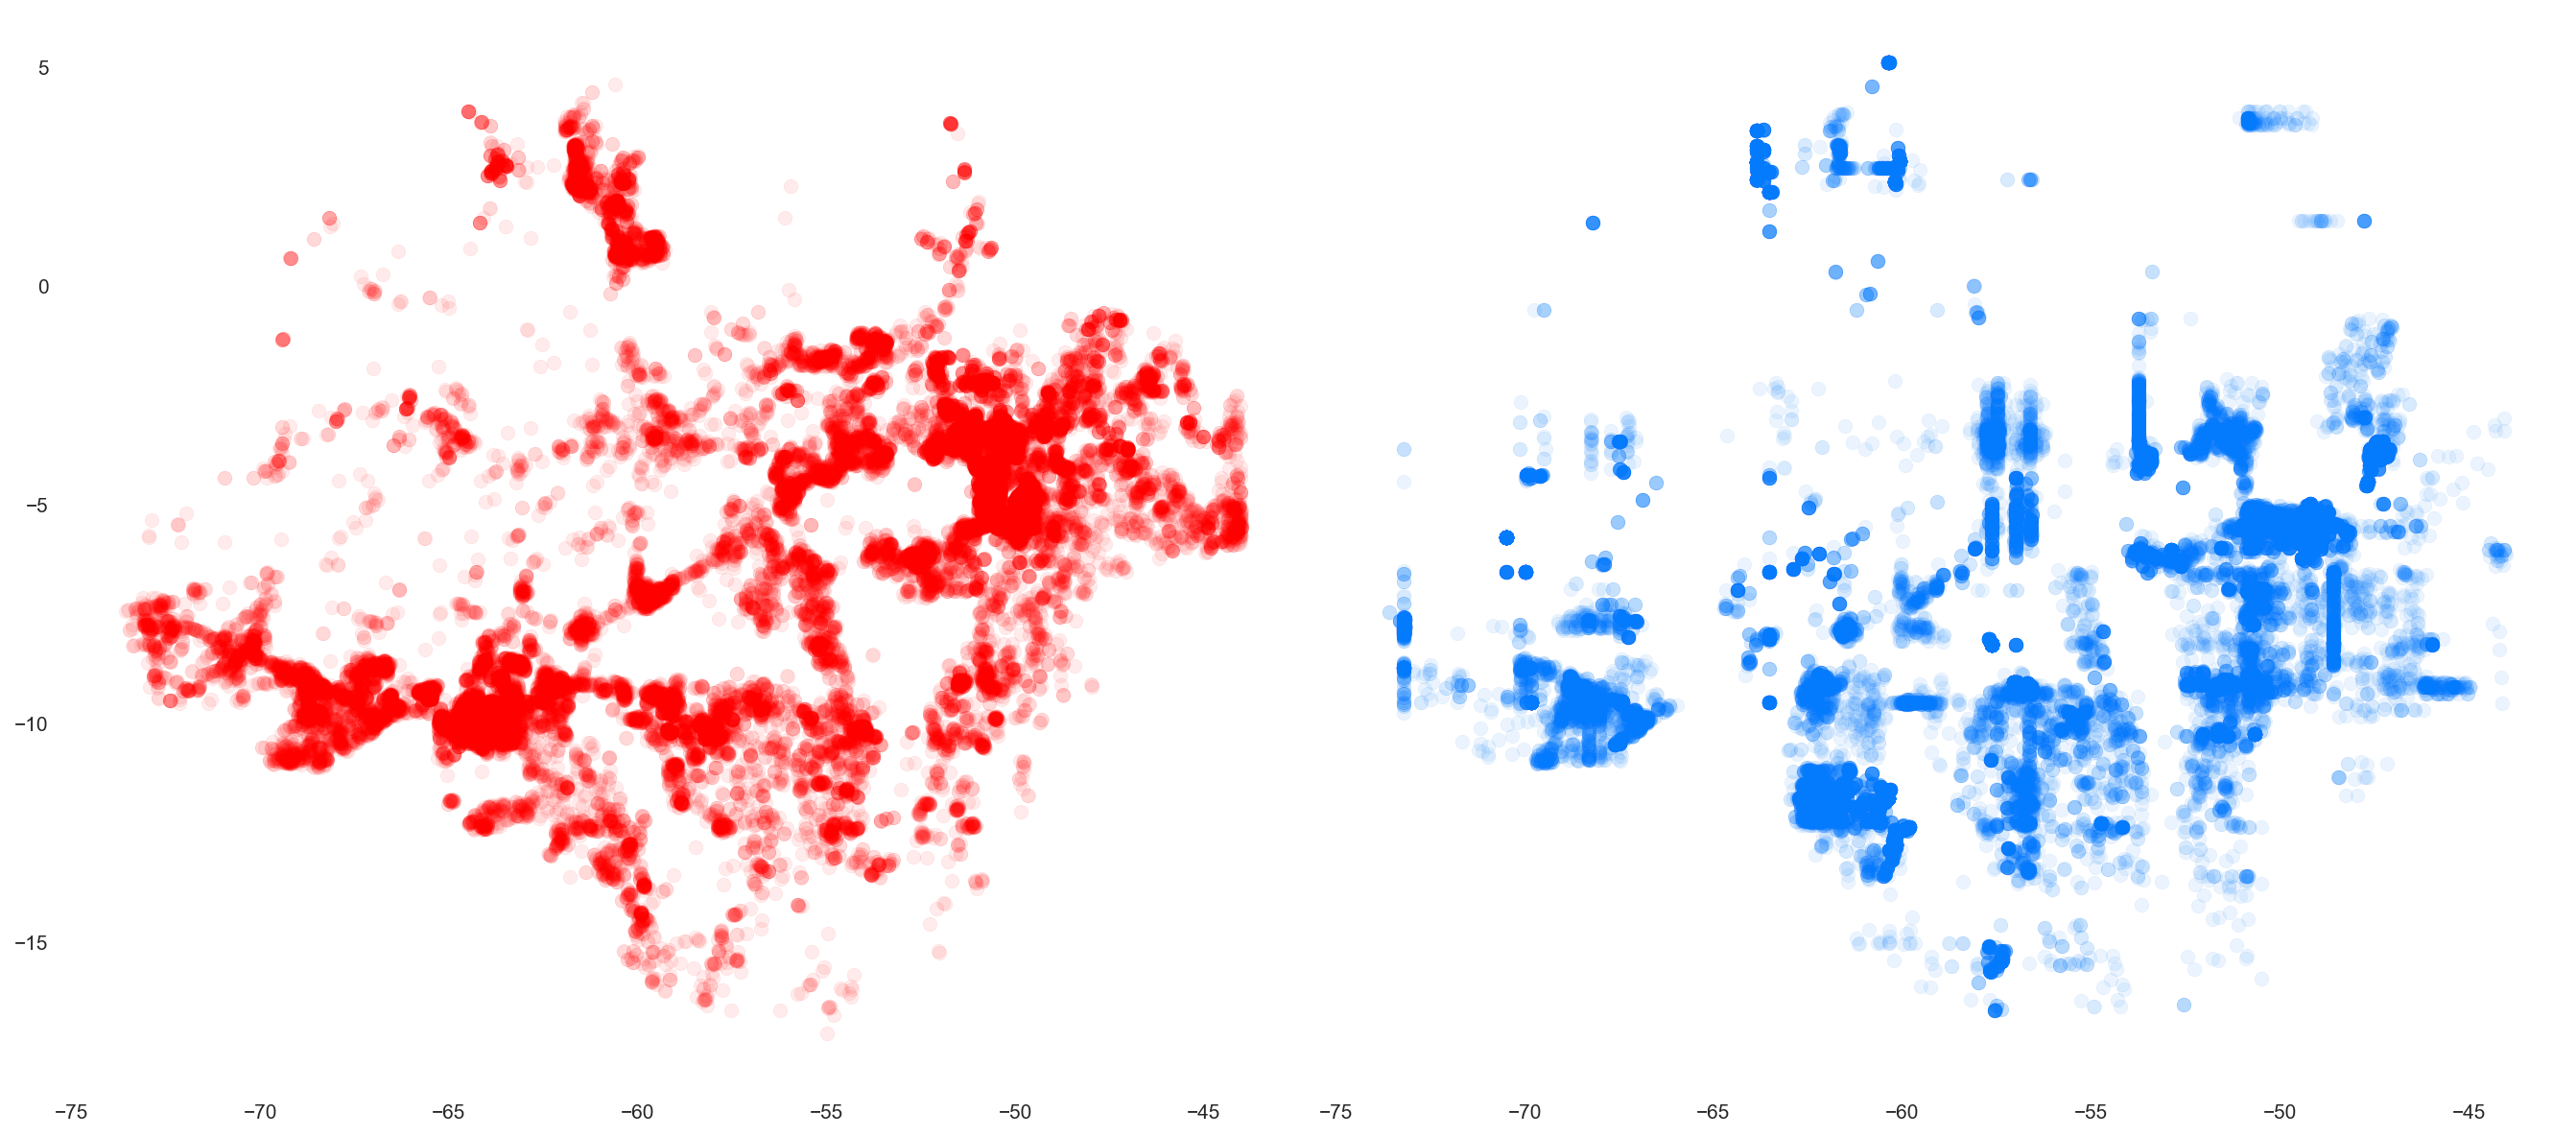

In [50]:
# true vs predicted values visualization population set
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(18,8))

axs[0].scatter(x=y_val_2, y=y_val_1, c='red', alpha=0.08)
axs[1].scatter(x=y_val_pred_2, y=y_val_pred_1, c='#037bfc', alpha=0.08);

In [50]:
# Randomized Search for random Forest
from scipy.stats import randint, uniform
pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 600),    
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 300), 
    'randomforestregressor__max_features': uniform(0, 1), 
}

search1 = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
search2 = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search1.fit(X_train, y_train_1);
search2.fit(X_train, y_train_2);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  4.3min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  4.7min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  9.3min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  9.4min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  9.8min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.0min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  6.6min remaining: 11.5min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  7.8min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  9.6min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  9.8min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 12.5min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.3min finished


In [52]:
search1.best_estimator_

Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['states'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               min_samples_leaf=8, return_df=True,
                               smoothing=1.0, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features=0.062435422463311796,
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       

In [53]:
search1.best_params_

{'randomforestregressor__max_features': 0.062435422463311796,
 'randomforestregressor__n_estimators': 65,
 'simpleimputer__strategy': 'median',
 'targetencoder__min_samples_leaf': 8}

In [54]:
search2.best_params_

{'randomforestregressor__max_features': 0.6735515094688472,
 'randomforestregressor__n_estimators': 273,
 'simpleimputer__strategy': 'mean',
 'targetencoder__min_samples_leaf': 183}

In [51]:
# Random Forest model trained on population
# Random forest
rf1 = make_pipeline( 
    ce.TargetEncoder(min_samples_leaf=54),
#     ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestRegressor(n_estimators=108, random_state=42, n_jobs=-1, max_features=0.31276908252447455)
)

rf2 = make_pipeline(
    ce.TargetEncoder(min_samples_leaf=329),
#     ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=186, random_state=42, n_jobs=-1, max_features=0.6404643986998269)
)
# max_depth (usually high, can try decreasing)
# n_estimators (too low underfits, too high wastes time)
# min_samples_leaf (increase if overfitting)
# max_features (decrease for more diverse trees)

rf1.fit(X_train, y_train_1)
y_val_pred_1 = rf1.predict(X_val)
rf2.fit(X_train, y_train_2)
y_val_pred_2 = rf2.predict(X_val)
print(f'Random Forest Validation MAE: {mean_absolute_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'Random Forest Validation MAE: {mean_absolute_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'Random Forest Validation RMSE loss: {mean_squared_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'Random Forest Validation RMSE loss: {mean_squared_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'Random Forest Validation R^2 coefficient: {r2_score(y_val_1, y_val_pred_1):.4f} lat')
print(f'Random Forest Validation R^2 coefficient: {r2_score(y_val_2, y_val_pred_2):.4f} lon')

Random Forest Validation MAE: 1.6633 lat
Random Forest Validation MAE: 2.9025 lon
Random Forest Validation RMSE loss: 4.3909 lat
Random Forest Validation RMSE loss: 11.7841 lon
Random Forest Validation R^2 coefficient: 0.6821 lat
Random Forest Validation R^2 coefficient: 0.7415 lon


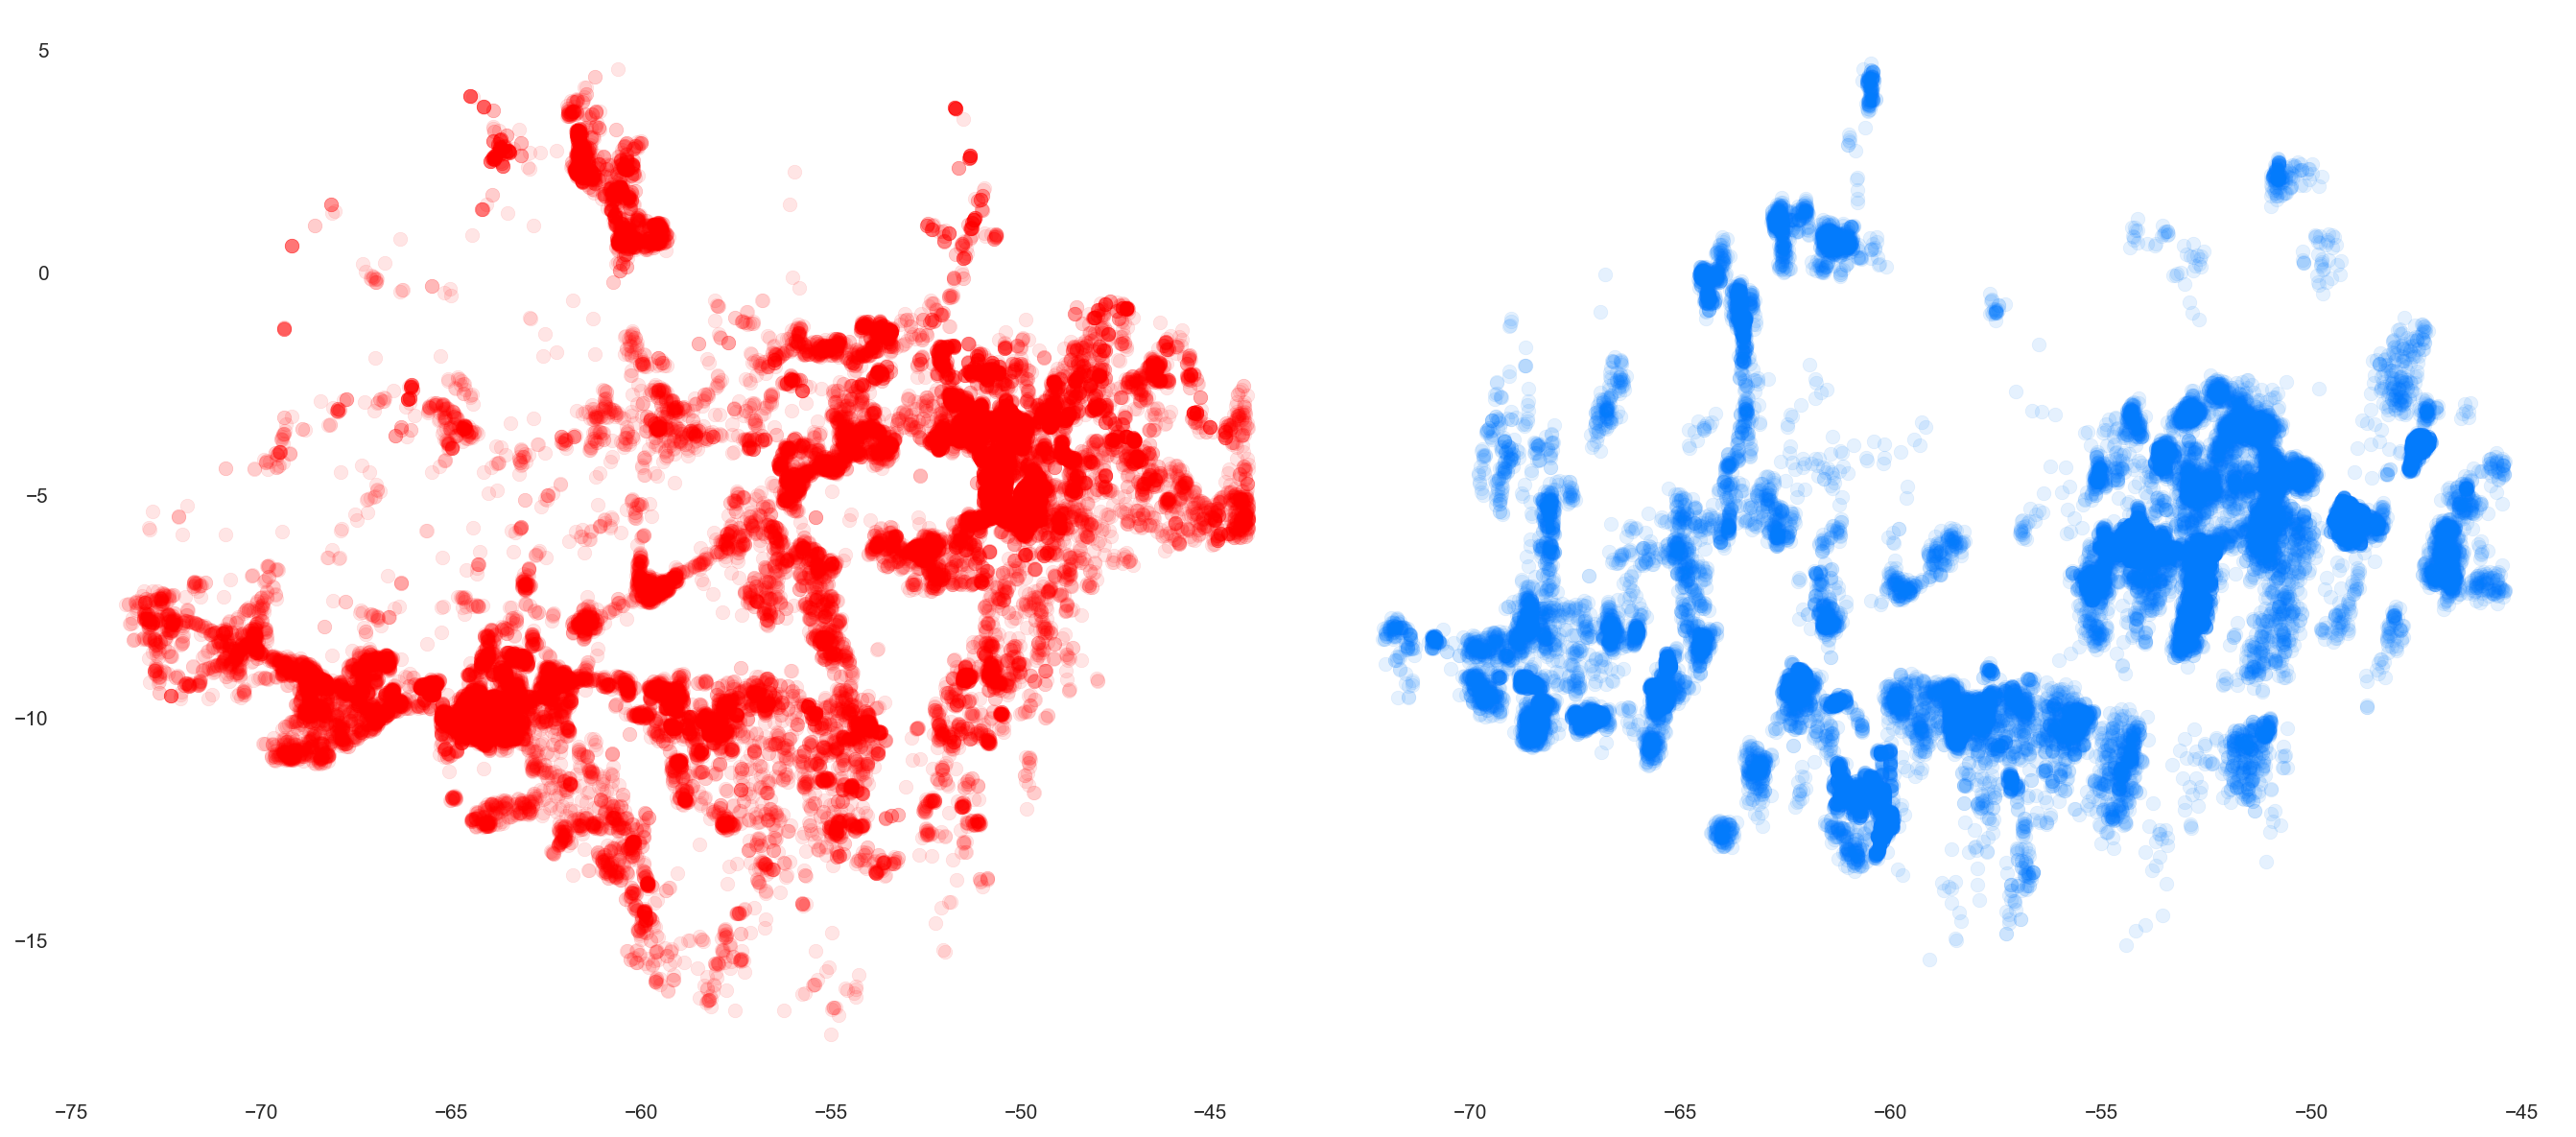

In [52]:
# true vs predicted values visualization population set
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(18,8))

axs[0].scatter(x=y_val_2, y=y_val_1, c='red', alpha=0.1)
axs[1].scatter(x=y_val_pred_2, y=y_val_pred_1, c='#037bfc', alpha=0.1);

In [ ]:
# visualize with plotly (very heavy for heroku)
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(mode = 'markers',
               x=y_val_2, 
               y=y_val_1,
               marker = dict(
               color='rgb(17, 157, 255)',
               opacity=0.5,
               size= 5)),
    row=1, 
    col=1
)

fig.add_trace(
    go.Scatter(mode = 'markers',
               x=y_val_pred_2, 
               y=y_val_pred_1,
               marker = dict(
               color='#E51313',
               opacity=0.5,
               size=5)),
    row=1, col=2
)

fig.update_xaxes(title_text="True Longitude", row=1, col=1)
fig.update_xaxes(title_text="Predicted Longitude", row=1, col=2)
fig.update_yaxes(title_text="True Latitude", row=1, col=1)
fig.update_yaxes(title_text="Predicted Latitude", row=1, col=2)

fig.update_layout(height=500, width=1100, showlegend=False,
                  title_text="Random Forest model prediction True vs Predicted values",
                  xaxis = dict(
                  tickmode = 'array',
                  tickvals = [-70,-65,-60, -55, -50,-45]
    ))
fig.show()

In [53]:
# XGBoost Regressor trained on population
encoder = ce.ordinal.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model1 = XGBRegressor(
    n_estimators=1000, # upper threshold
    max_depth=100,
    learning_rate=0.4, 
    n_jobs=-1
)
model2 = XGBRegressor(
    n_estimators=1000, # upper threshold
    max_depth=100,
    learning_rate=0.4, 
    n_jobs=-1
)

eval_set1 = [(X_train_encoded, y_train_1), 
            (X_val_encoded, y_val_1)]
eval_set2 = [(X_train_encoded, y_train_2), 
            (X_val_encoded, y_val_2)]

model1.fit(X_train_encoded, y_train_1,
          eval_set=eval_set1,
          eval_metric='rmse',
          early_stopping_rounds=50)
model2.fit(X_train_encoded, y_train_2,
          eval_set=eval_set2,
          eval_metric='rmse',
          early_stopping_rounds=50)

[0]	validation_0-rmse:4.53217	validation_1-rmse:4.49223
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2.83481	validation_1-rmse:2.77654
[2]	validation_0-rmse:1.85339	validation_1-rmse:2.14483
[3]	validation_0-rmse:1.28933	validation_1-rmse:2.03968
[4]	validation_0-rmse:0.95254	validation_1-rmse:2.10918
[5]	validation_0-rmse:0.72568	validation_1-rmse:2.16943
[6]	validation_0-rmse:0.56376	validation_1-rmse:2.22731
[7]	validation_0-rmse:0.44876	validation_1-rmse:2.27549
[8]	validation_0-rmse:0.35868	validation_1-rmse:2.31323
[9]	validation_0-rmse:0.28779	validation_1-rmse:2.34780
[10]	validation_0-rmse:0.23253	validation_1-rmse:2.37457
[11]	validation_0-rmse:0.18911	validation_1-rmse:2.39193
[12]	validation_0-rmse:0.15412	validation_1-rmse:2.40822
[13]	validation_0-rmse:0.12673	validation_1-rmse:2.41921
[14]	validation_0-rmse:0.10453	validation_1-rmse:2.42

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.4, max_delta_step=0, max_depth=100,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [58]:
model1.best_ntree_limit

4

In [59]:
model2.best_ntree_limit

8

In [54]:
# XGBoost trained on population

xgb1 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=50)
)
xgb2 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=50)
)
xgb1.fit(X_train, y_train_1)
y_val_pred_1 = xgb1.predict(X_val)
xgb2.fit(X_train, y_train_2)
y_val_pred_2 = xgb2.predict(X_val)
print(f'XGBoost Validation MAE: {mean_absolute_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'XGBoost Validation MAE: {mean_absolute_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'XGBoost Validation RMSE loss: {mean_squared_error(y_val_1, y_val_pred_1):.4f} lat')
print(f'XGBoost Validation RMSE loss: {mean_squared_error(y_val_2, y_val_pred_2):.4f} lon')
print(f'XGBoost Validation R^2 coefficient: {r2_score(y_val_1, y_val_pred_1):.4f} lat')
print(f'XGBoost Validation R^2 coefficient: {r2_score(y_val_2, y_val_pred_2):.4f} lon')

XGBoost Validation MAE: 1.9271 lat
XGBoost Validation MAE: 3.2067 lon
XGBoost Validation RMSE loss: 5.9052 lat
XGBoost Validation RMSE loss: 14.5532 lon
XGBoost Validation R^2 coefficient: 0.5724 lat
XGBoost Validation R^2 coefficient: 0.6808 lon


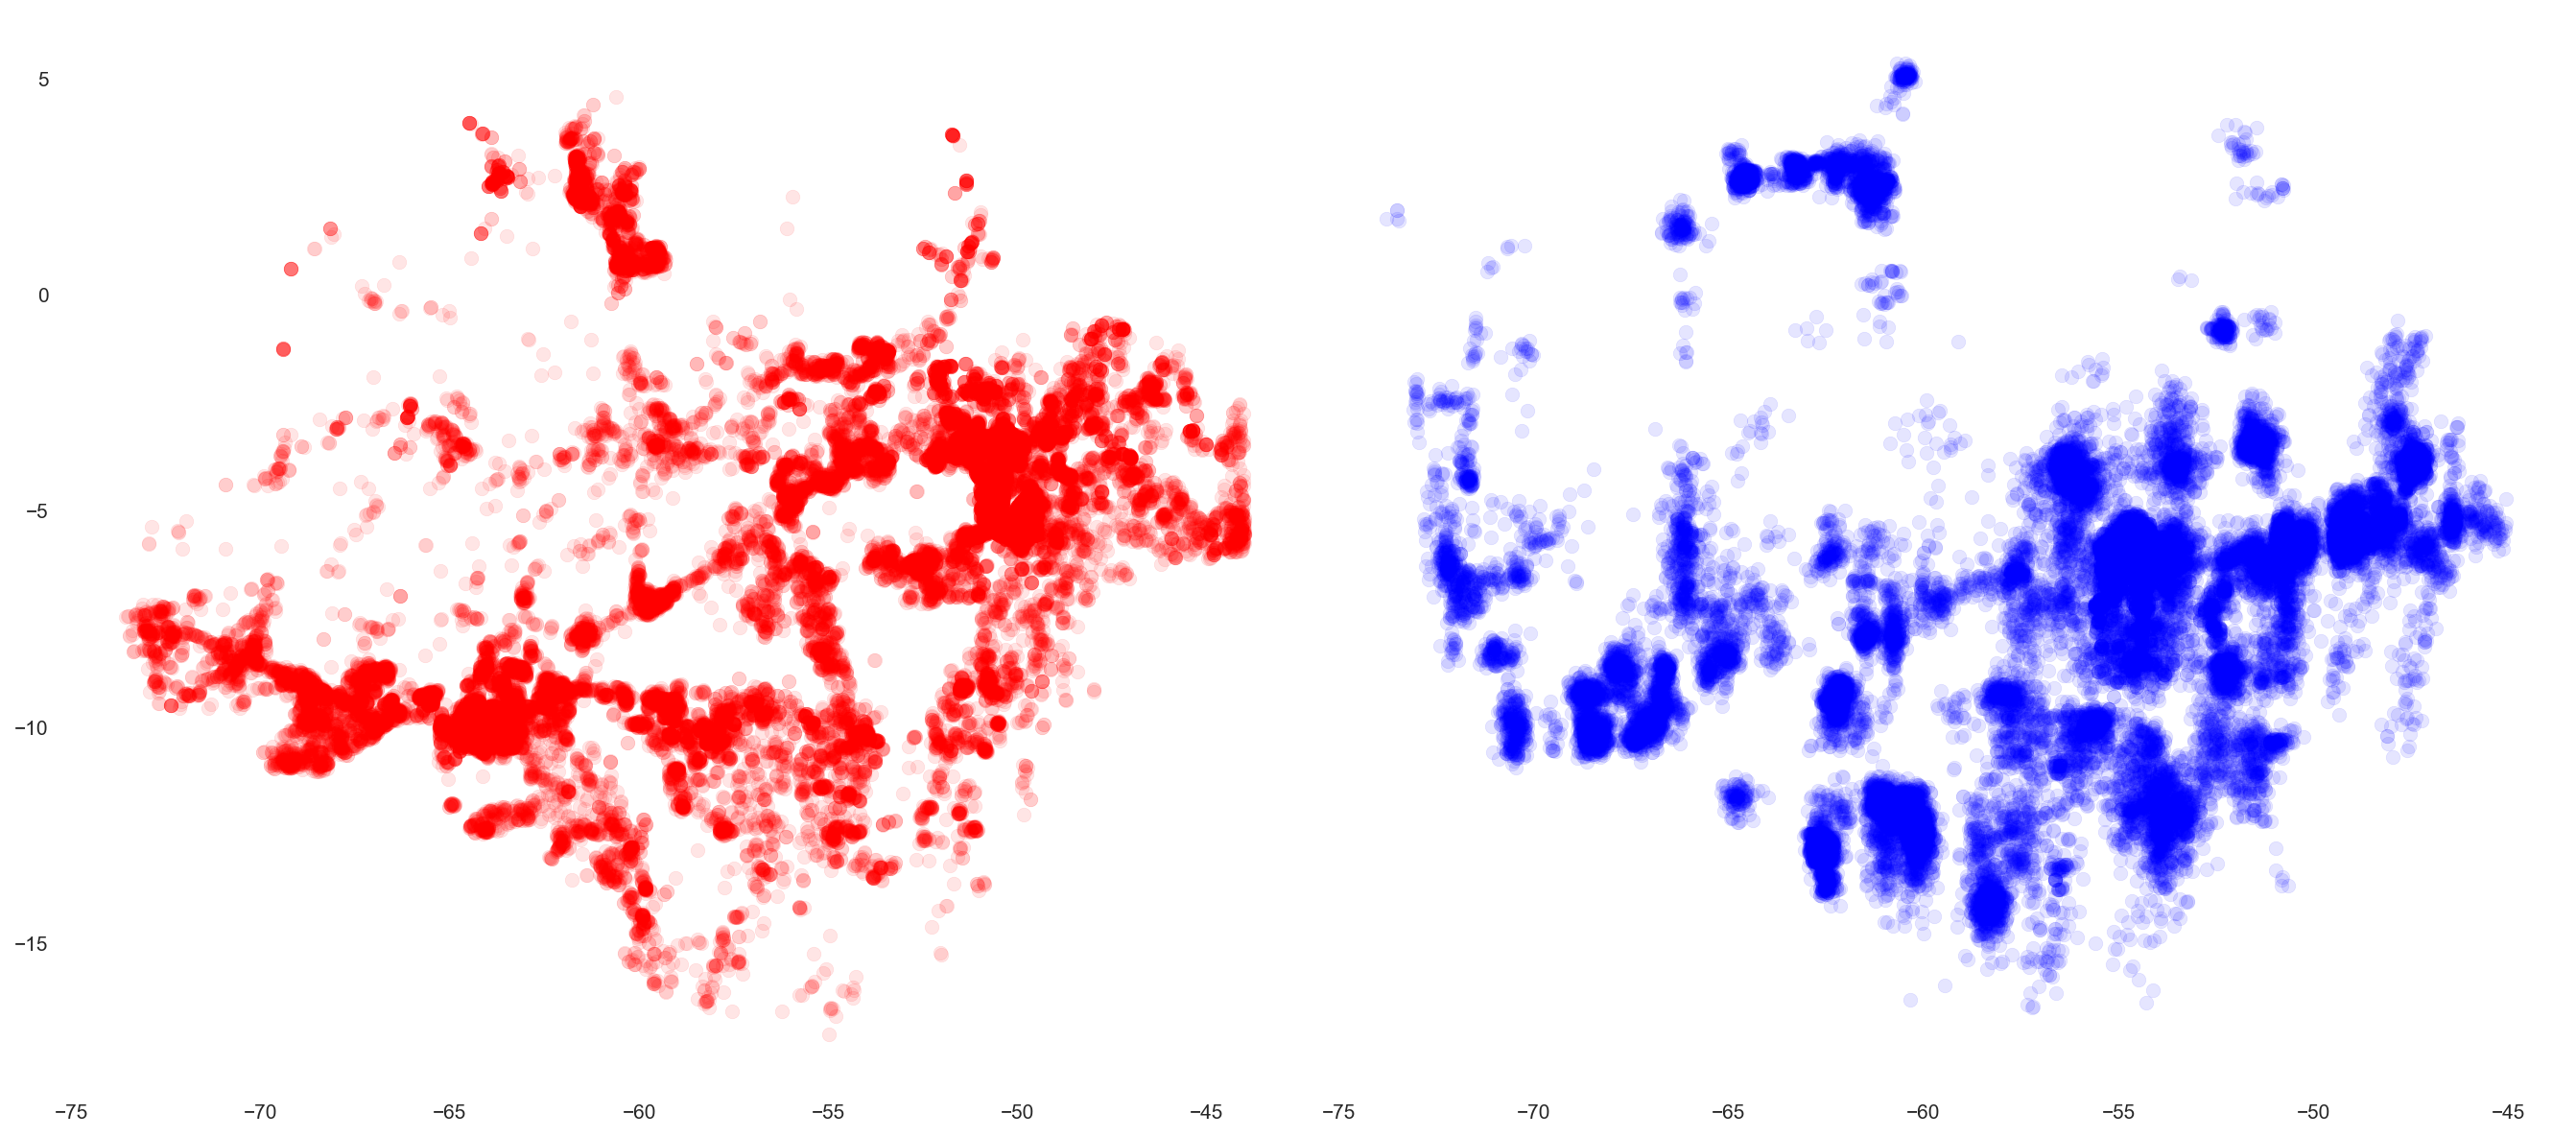

In [56]:
# true vs predicted values with xgboost visualization population set
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(18,8))

axs[0].scatter(x=y_val_2, y=y_val_1, c='red', alpha=0.1)
axs[1].scatter(x=y_val_pred_2, y=y_val_pred_1, c='blue', alpha=0.1);

In [ ]:
# visualize with plotly (very heavy for heroku app)
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(mode = 'markers',
               x=y_val_2, 
               y=y_val_1,
               marker = dict(
               color='rgba(17, 157, 255, 0.5)',
               size= 5)),
    row=1, 
    col=1
)

fig.add_trace(
    go.Scatter(mode = 'markers',
               x=y_val_pred_2, 
               y=y_val_pred_1,
               marker = dict(
               color='#E51313',
               opacity=0.5,
               size=5)),
    row=1, col=2
)

fig.update_xaxes(title_text="True Longitude", row=1, col=1)
fig.update_xaxes(title_text="Predicted Longitude", row=1, col=2)
fig.update_yaxes(title_text="True Latitude", row=1, col=1)
fig.update_yaxes(title_text="Predicted Latitude", row=1, col=2)

fig.update_layout(height=500, width=1100, showlegend=False,
                  title_text="XGBoost model prediction True vs Predicted values")
fig.show()

In [57]:
# transform for eli5 (eli5 chech how features contribute)
transformers = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer()
)

X_train_tranformed = transformers.fit_transform(X_train)
X_val_tranformed = transformers.transform(X_val)

In [58]:
# Permutation Importance for feature contribution
import eli5
from eli5.sklearn import PermutationImportance

model1 = RandomForestRegressor(n_estimators=108, random_state=42, n_jobs=-1, max_features=0.31276908252447455)
model1.fit(X_train_tranformed, y_train_1)
model2 = RandomForestRegressor(n_estimators=186, random_state=42, n_jobs=-1, max_features=0.6404643986998269)
model2.fit(X_train_tranformed, y_train_2)

permuter1 = PermutationImportance(
    model1,
    scoring='neg_mean_squared_error',
    n_iter=5,
    random_state=42
)
permuter2 = PermutationImportance(
    model2,
    scoring='neg_mean_squared_error',
    n_iter=5,
    random_state=42
)

permuter1.fit(X_val_tranformed, y_val_1)
permuter2.fit(X_val_tranformed, y_val_2)

C:\Users\tigju\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

C:\Users\tigju\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features=0.6404643986998269,
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_es

In [59]:
feature_names = X_val.columns.to_list()
pd.Series(permuter1.feature_importances_, feature_names).sort_values(ascending=True)

year              0.000000
areakm_squared    0.242924
day               0.291873
month             1.108684
states            9.922554
dtype: float64

In [61]:
feature_names = X_val.columns.to_list()
pd.Series(permuter2.feature_importances_, feature_names).sort_values(ascending=True)

day              -1.969891e+00
areakm_squared   -3.994789e-01
year              7.105427e-16
month             3.638591e-01
states            7.815475e+01
dtype: float64

In [62]:
eli5.show_weights(permuter1, 
                  top=None, # How many best feature to diplay. None == all
                  feature_names=feature_names)

In [63]:
eli5.show_weights(permuter2, 
                  top=None, # How many best feature to diplay. None == all
                  feature_names=feature_names)

In [64]:
# Use to see contribution per feature
import shap

In [65]:
# define function for predictions with Random Forest (trained on population)
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)

randomf1 = RandomForestRegressor(n_estimators=108, random_state=42, n_jobs=-1, max_features=0.31276908252447455)
randomf2 = RandomForestRegressor(n_estimators=186, random_state=42, n_jobs=-1, max_features=0.6404643986998269)

randomf1.fit(X_train_encoded, y_train_1)
randomf2.fit(X_train_encoded, y_train_2)

def predict(areakm_squared, day, month, year, states):

    # Make dataframe from the inputs
    df1 = pd.DataFrame(
        data=[[areakm_squared, day, month, year, states]], 
        columns=['areakm_squared', 'day', 'month', 'year', 'states']
    )
    df2 = pd.DataFrame(
        data=[[areakm_squared, day, month, year, states]], 
        columns=['areakm_squared', 'day', 'month', 'year', 'states']
    )
    
    # encode 
    df1_encoded = encoder.transform(df1)
    df2_encoded = encoder.transform(df2)
    # Get the model's prediction
    pred1 = randomf1.predict(df1_encoded)[0]
    pred2 = randomf2.predict(df2_encoded)[0]
    
    # Calculate shap values
    explainer1 = shap.TreeExplainer(randomf1)
    explainer2 = shap.TreeExplainer(randomf2)
    shap_values1 = explainer1.shap_values(df1_encoded)
    shap_values2 = explainer2.shap_values(df2_encoded)

    # Get series with shap values, feature names, & feature values
    feature_names1 = df1.columns
    feature_values1 = df1.values[0]
    shaps1 = pd.Series(shap_values1[0], zip(feature_names1, feature_values1))
    
    feature_names2 = df2.columns
    feature_values2 = df2.values[0]
    shaps2 = pd.Series(shap_values2[0], zip(feature_names2, feature_values2))

    # Print results
    result1 = f'{pred1:.4f} estimated latitude for location. \n\n'
    result1 += f'Starting from baseline of {explainer1.expected_value} \n'
    result1 += shaps1.to_string()
    result2 = f'{pred2:.4f} estimated longitude for location. \n\n'
    result2 += f'Starting from baseline of {explainer2.expected_value} \n'
    result2 += shaps2.to_string()
    print(result1)
    print(result2)


    # Show shapley values force plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer1.expected_value, 
        shap_values=shap_values1, 
        features=df1), shap.force_plot(
        base_value=explainer2.expected_value, 
        shap_values=shap_values2, 
        features=df2)

In [69]:
# predictions for random values
location = predict(0.05, 15, 7, 2018, 'Para')

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


-3.3767 estimated latitude for location. 

Starting from baseline of [-5.94819043] 
(areakm_squared, 0.05)    0.445236
(day, 15)                 0.440437
(month, 7)               -0.191920
(year, 2018)              0.482194
(states, Para)            1.395518
-51.1362 estimated longitude for location. 

Starting from baseline of [-55.21367171] 
(areakm_squared, 0.05)    0.234178
(day, 15)                -0.026427
(month, 7)                0.462677
(year, 2018)             -0.226518
(states, Para)            3.633552


In [ ]:
# latitude (how each feature contributed)
location[0]

In [ ]:
# longitude (how each feature contributed)
location[1]

In [72]:
# take a random row from val set
val_row = X_val.iloc[[200]]
val_row

areakm_squared  day  month  year states
4667        0.058642   30      7  2016   Acre

In [73]:
# predict for a random row from val set
row_tranformed = encoder.transform(val_row)
explainer1 = shap.TreeExplainer(randomf1)
explainer2 = shap.TreeExplainer(randomf2)
shap_values1 = explainer1.shap_values(row_tranformed)
shap_values2 = explainer2.shap_values(row_tranformed)
shap_values1, shap_values2

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


(array([[ 0.1108349 , -0.71450833, -1.03033844, -0.29798886, -2.22623939]]),
 array([[ -0.14588482,  -0.09847643,   0.32988876,   0.20014932,
         -12.42043648]]))

In [ ]:
# latitude (how each feature contributed)
shap.initjs()
shap.force_plot(
    base_value=explainer1.expected_value, 
    shap_values=shap_values1, 
    features=row_tranformed)

In [ ]:
# longitude (how each feature contributed)
shap.force_plot(
    base_value=explainer2.expected_value, 
    shap_values=shap_values2, 
    features=row_tranformed)

In [76]:
############## PREDICT ON A ROW FROM TEST SET USING RANDOM FOREST AND XGBOOST MODELS

In [77]:
# true values from val set
print(y_val_1.iloc[[200]])
print(y_val_2.iloc[[200]])

4667   -9.0149
Name: lat, dtype: float64
4667   -69.2313
Name: lon, dtype: float64


In [78]:
# predicted values random forest
rf1.predict(val_row), rf2.predict(val_row)

(array([-10.21972407]), array([-67.38061147]))

In [79]:
# predicted values xgboost
xgb1.predict(val_row), xgb2.predict(val_row)

(array([-10.153294], dtype=float32), array([-67.42607], dtype=float32))

In [80]:
#############################################################

In [81]:
########### PREDICTIONS ON TEST SET USING RANDOM FOREST

In [82]:
# take single row - use for predictions (test set) 
test_row = X_test.iloc[[0]]
test_row

areakm_squared  day  month  year   states
0        0.016815   22      7  2018  Roraima

In [83]:
# true values from test set
y_test_1.iloc[[0]], y_test_2.iloc[[0]]

(0    4.0081
 Name: lat, dtype: float64, 0   -64.51
 Name: lon, dtype: float64)

In [84]:
# predicted values random forest
rf1.predict(test_row), rf2.predict(test_row)

(array([-1.96812002]), array([-63.26968477]))

In [85]:
# predicted values xgboost
xgb1.predict(test_row), xgb2.predict(test_row)

(array([2.9151788], dtype=float32), array([-61.88295], dtype=float32))

In [86]:
# final prediction on test 
y_pred_1 = rf1.predict(X_test)
y_pred_2 = rf2.predict(X_test)

In [87]:
# metrics on test predictions
print(f'Random Forest Test MAE: {mean_absolute_error(y_test_1, y_pred_1):.4f} lat')
print(f'Random Forest Test MAE: {mean_absolute_error(y_test_2, y_pred_2):.4f} lon')
print(f'Random Forest Test RMSE loss: {mean_squared_error(y_test_1, y_pred_1):.4f} lat')
print(f'Random Forest Test RMSE loss: {mean_squared_error(y_test_2, y_pred_2):.4f} lon')
print(f'Random Forest Test R^2 coefficient: {r2_score(y_test_1, y_pred_1):.4f} lat')
print(f'Random Forest Test R^2 coefficient: {r2_score(y_test_2, y_pred_2):.4f} lon')

Random Forest Test MAE: 1.9317 lat
Random Forest Test MAE: 2.6541 lon
Random Forest Test RMSE loss: 5.9613 lat
Random Forest Test RMSE loss: 11.3523 lon
Random Forest Test R^2 coefficient: 0.5621 lat
Random Forest Test R^2 coefficient: 0.7733 lon


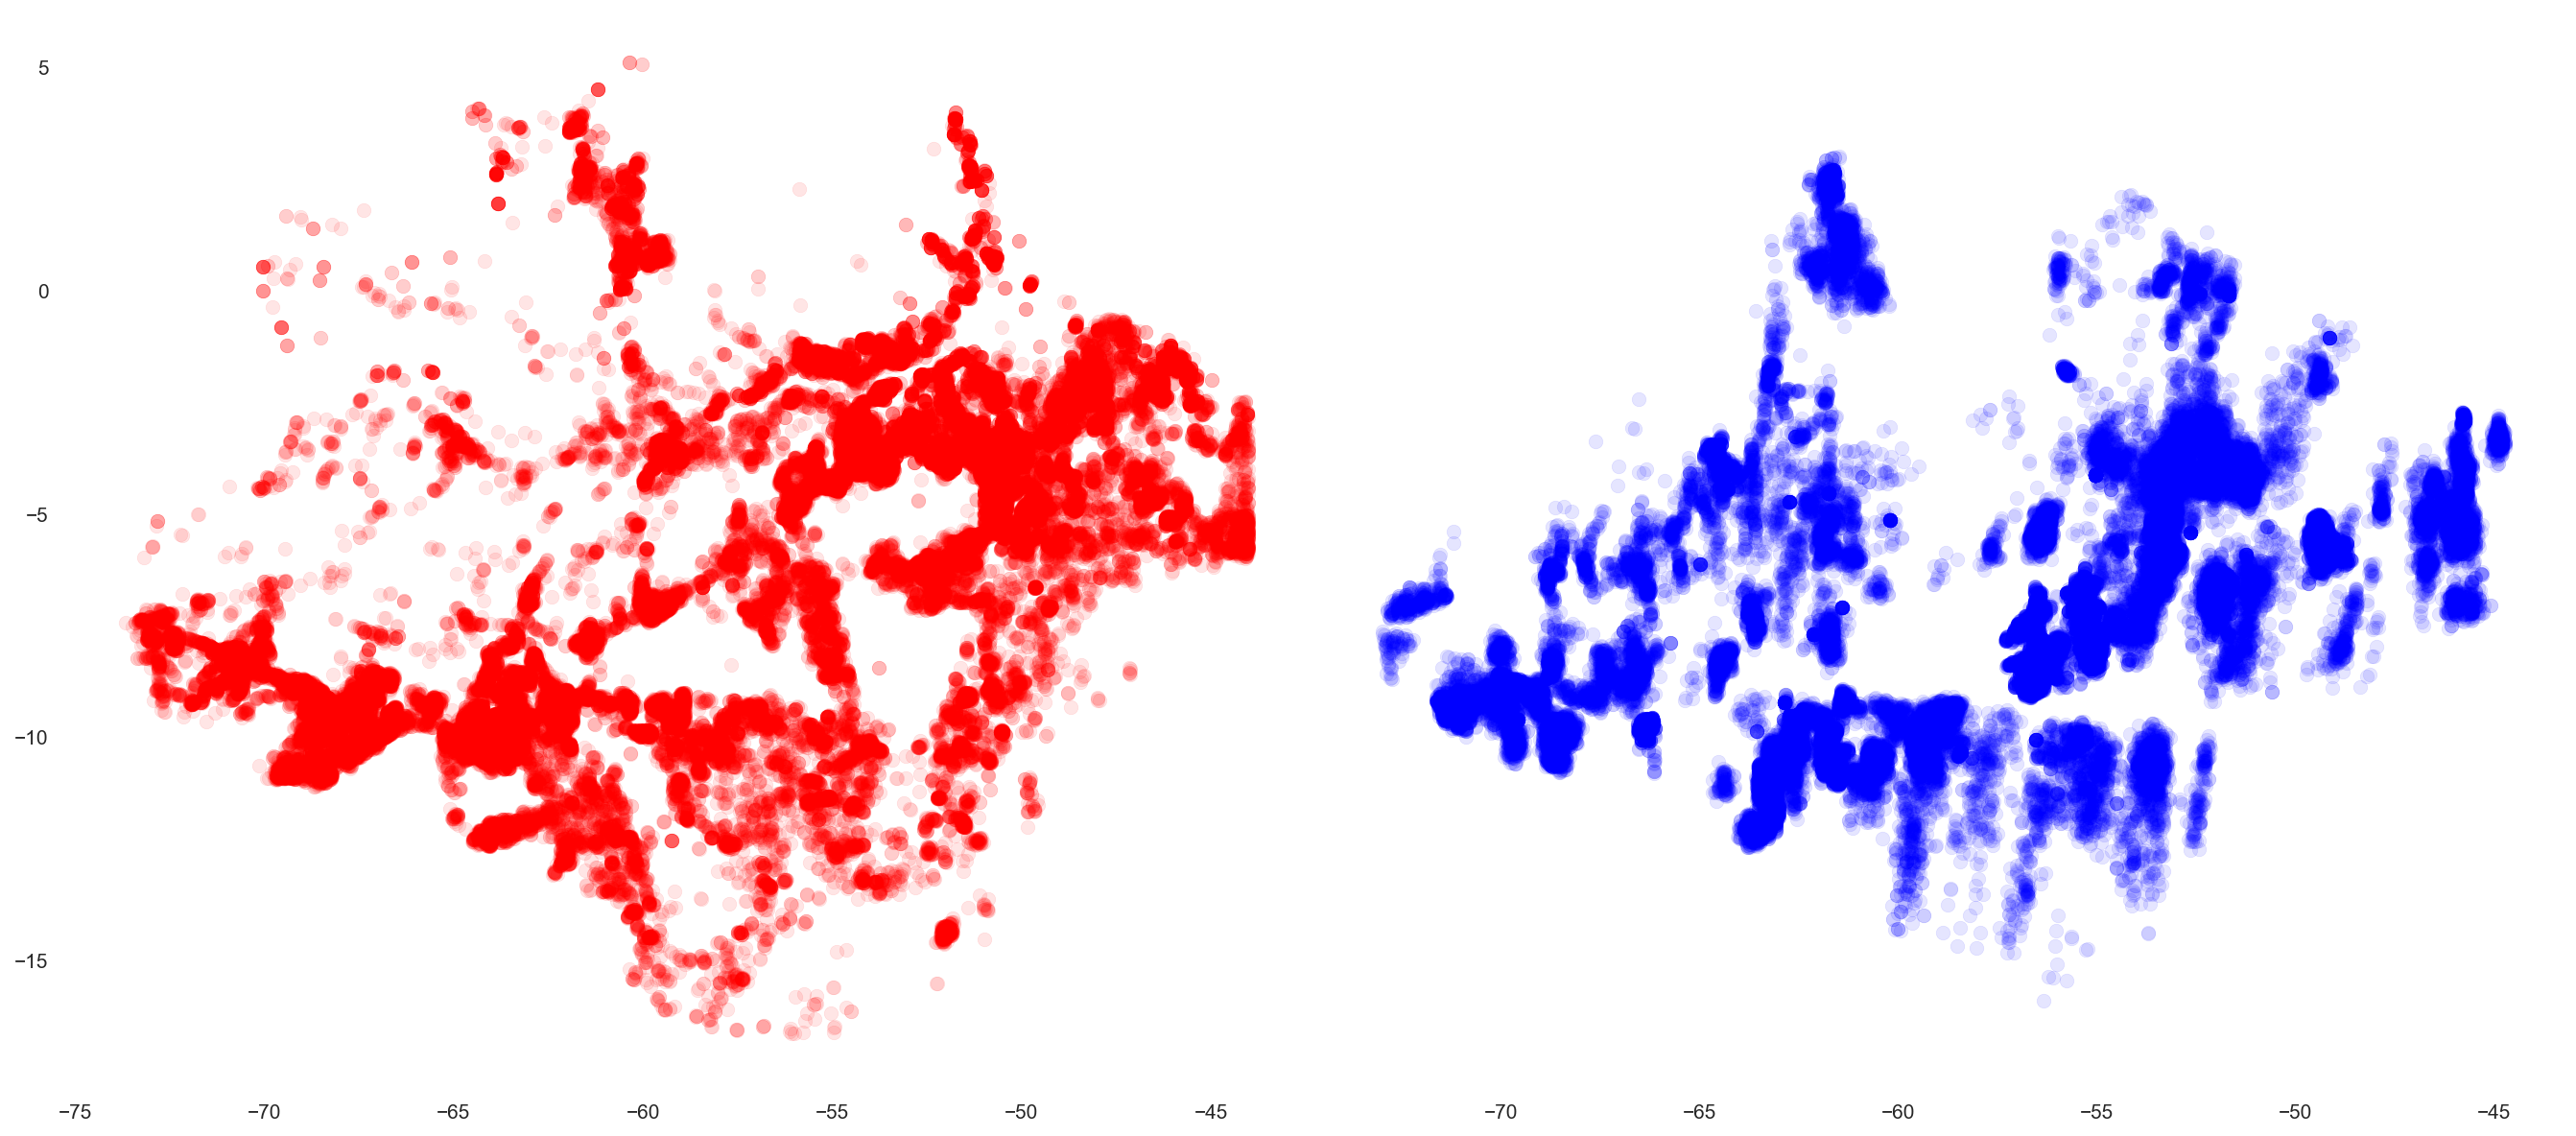

In [88]:
# visualize matplotlib
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(18,8))

axs[0].scatter(x=y_test_2, y=y_test_1, c='red', alpha=0.1)
axs[1].scatter(x=y_pred_2, y=y_pred_1, c='blue', alpha=0.1);

In [ ]:
# same visualization with plotly
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(mode = 'markers',
               x=y_test_2, 
               y=y_test_1,
               marker = dict(
               color='rgb(17, 157, 255)',
               opacity=0.5,
               size= 5)),
    row=1, 
    col=1
)

fig.add_trace(
    go.Scatter(mode = 'markers',
               x=y_pred_2, 
               y=y_pred_1,
               marker = dict(
               color='#E51313',
               opacity=0.5,
               size=5)),
    row=1, col=2
)

fig.update_xaxes(title_text="True Longitude", row=1, col=1)
fig.update_xaxes(title_text="Predicted Longitude", row=1, col=2)
fig.update_yaxes(title_text="True Latitude", row=1, col=1)
fig.update_yaxes(title_text="Predicted Latitude", row=1, col=2)

fig.update_layout(height=500, width=1100, showlegend=False,
                  title_text="Random Forest model prediction True vs Predicted values")
fig.show()

In [ ]:
########### PREDICTIONS ON TEST SET USING XGBOOST

In [90]:
# final predictions with xgboost
y_pred_1 = xgb1.predict(X_test)
y_pred_2 = xgb2.predict(X_test)

In [91]:
# metrics
print(f'Random Forest Test MAE: {mean_absolute_error(y_test_1, y_pred_1):.4f} lat')
print(f'Random Forest Test MAE: {mean_absolute_error(y_test_2, y_pred_2):.4f} lon')
print(f'Random Forest Test RMSE loss: {mean_squared_error(y_test_1, y_pred_1):.4f} lat')
print(f'Random Forest Test RMSE loss: {mean_squared_error(y_test_2, y_pred_2):.4f} lon')
print(f'Random Forest Test R^2 coefficient: {r2_score(y_test_1, y_pred_1):.4f} lat')
print(f'Random Forest Test R^2 coefficient: {r2_score(y_test_2, y_pred_2):.4f} lon')

Random Forest Test MAE: 2.0560 lat
Random Forest Test MAE: 2.8309 lon
Random Forest Test RMSE loss: 6.7131 lat
Random Forest Test RMSE loss: 13.5584 lon
Random Forest Test R^2 coefficient: 0.5068 lat
Random Forest Test R^2 coefficient: 0.7292 lon


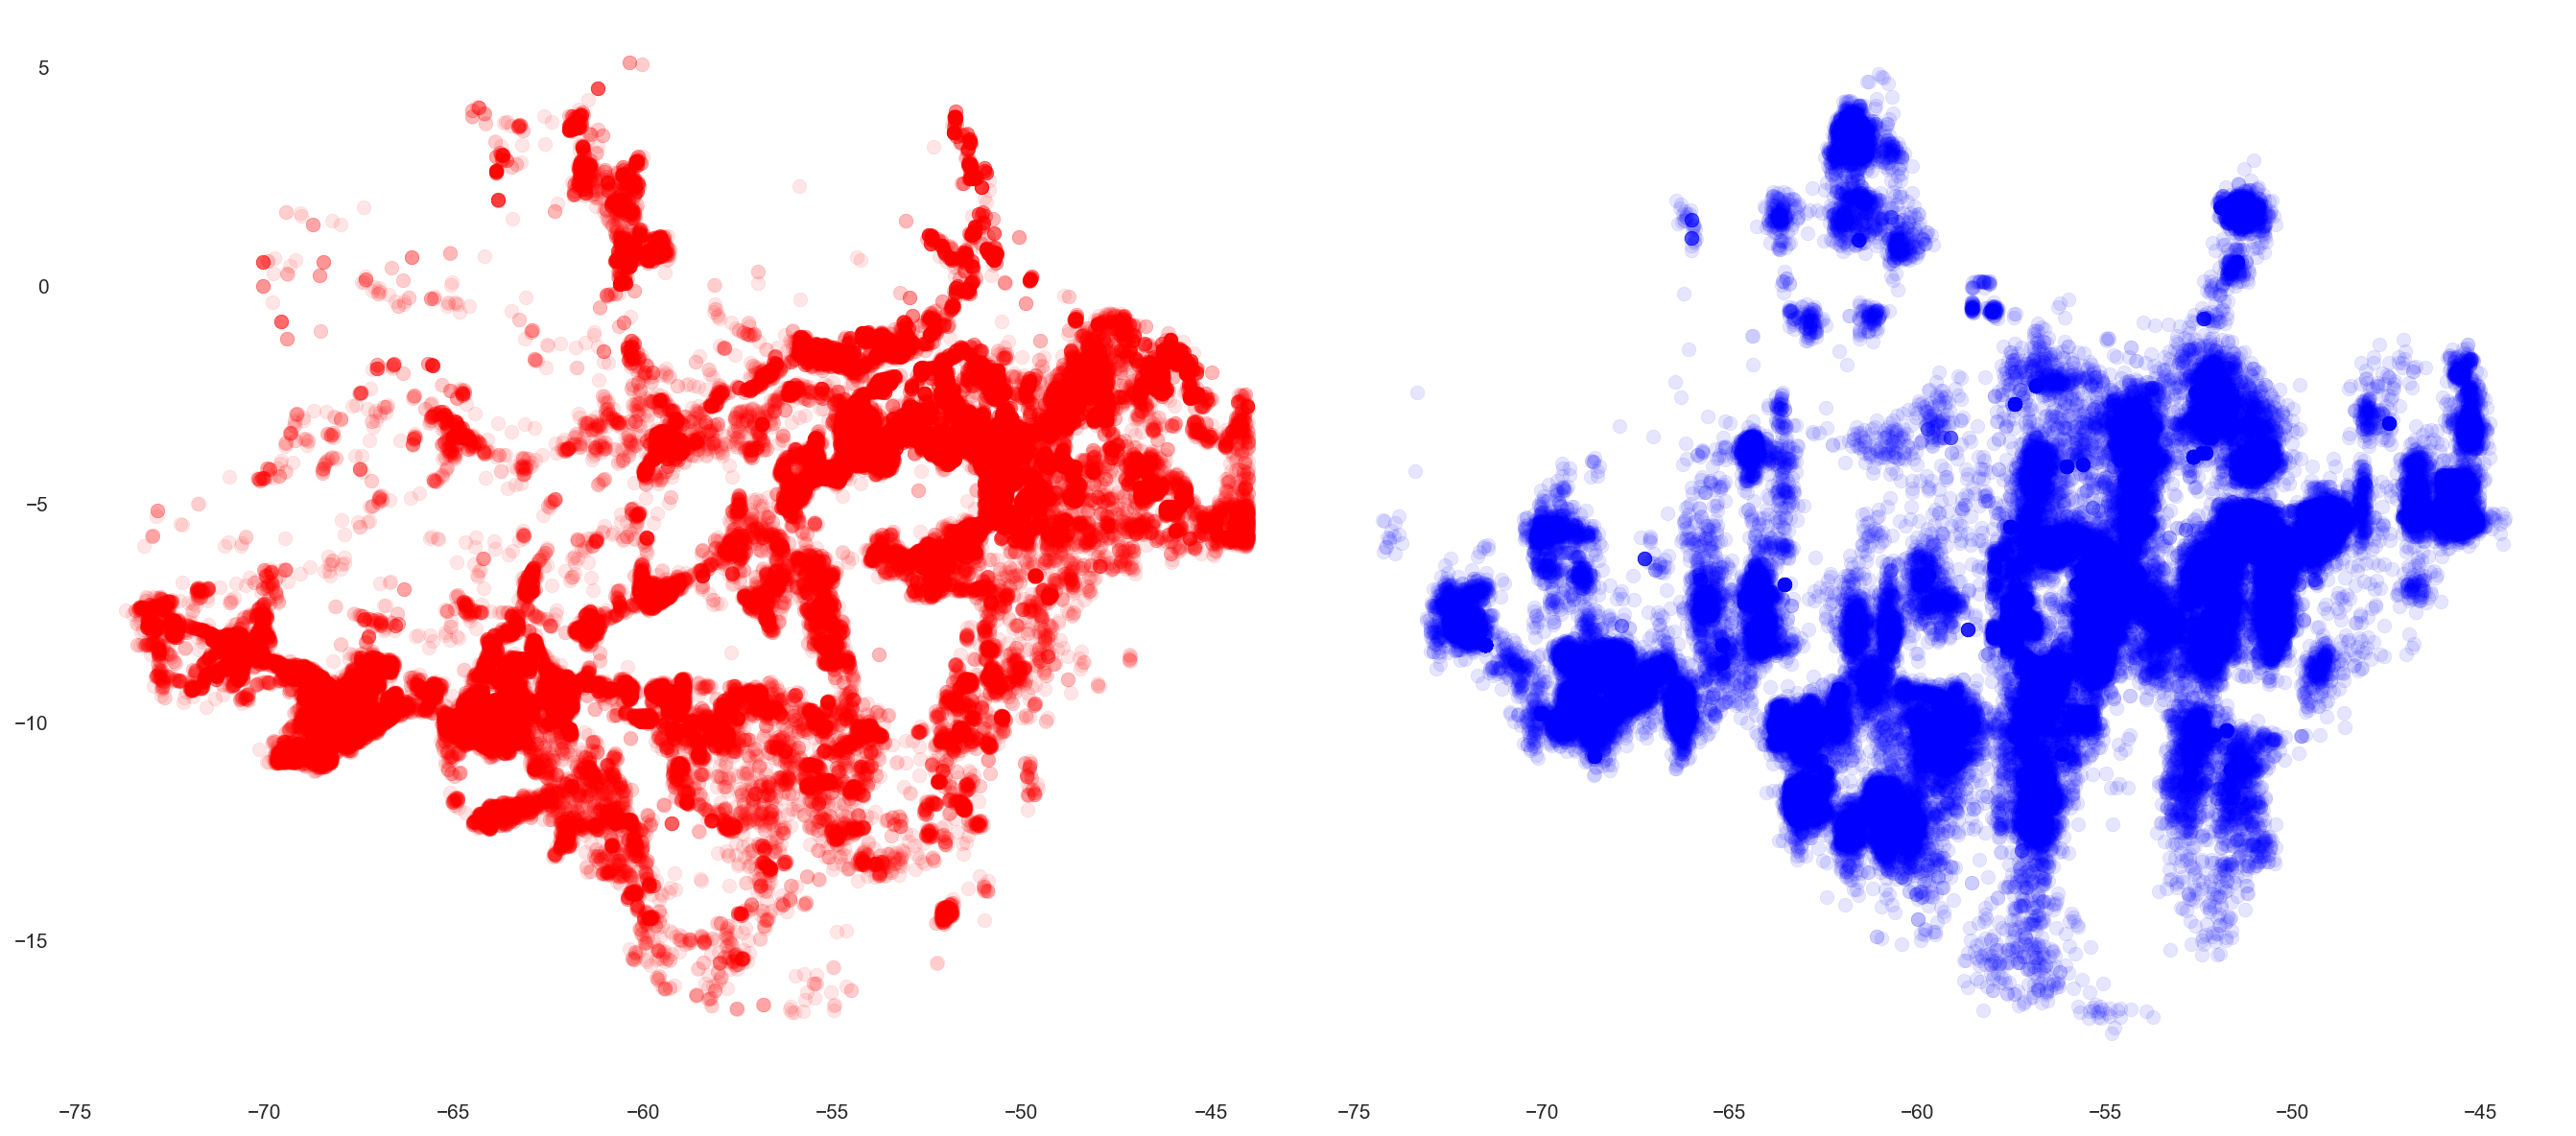

In [92]:
# visualize matplotlib
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(18,8))

axs[0].scatter(x=y_test_2, y=y_test_1, c='red', alpha=0.1)
axs[1].scatter(x=y_pred_2, y=y_pred_1, c='blue', alpha=0.1);

In [93]:
# define function with xgb model (xgboost peformed better for sample data) to use on heroku
def predict(areakm_squared, day, month, year, states):

    # Make dataframe from the inputs
    df = pd.DataFrame(
        data=[[areakm_squared, day, month, year, states]], 
        columns=['areakm_squared', 'day', 'month', 'year', 'states']
    )
    
    # Get the model's prediction
    pred1 = rf1.predict(df)[0]
    pred2 = rf2.predict(df)[0]

    print(pred1)
    print(pred2)

    results = f'Latitude {pred1}, Longitude {pred2}'
    return results

In [94]:
predict(0.03, 25, 3, 2017, 'Tocantis')

-5.4018527777777745
-53.463596093189985


'Latitude -5.4018527777777745, Longitude -53.463596093189985'